In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from numba import njit
from matplotlib.ticker import AutoMinorLocator


plt.style.use('Ltx.mplstyle')

Bad value in file 'Ltx.mplstyle', line 25 ("axes.prop_cycle: cycler(['#1d65c9', '#ff1a1a', '#ff6a00', '#ffd500', '#bfe500', '#7ee236'])"): Key axes.prop_cycle: "cycler(['" is not a valid cycler construction: unterminated string literal (detected at line 1) (<unknown>, line 1)


In [2]:
results_path = "../Code/Results/"
figures_path = "figures/"

figdir = "Figures/take5/"

In [3]:
"""COLOURS"""
AmC_DEEP_BLUE = '#1d65c9'
AmC_BRIGHT_RED = '#ff1a1a'
AmC_VIVID_ORANGE = '#ff6a00'
AmC_BOLD_YELLOW = '#ffd500'
AmC_LIGHT_GREEN = '#bfe500'
AmC_LIME_GREEN = '#7ee236'

Perc7_DKBLUE_1 = '#340498'
Perc7_PURPUR_2 = '#6c00a8'
Perc7_VIOLET_3 = '#a31d99'
Perc7_PINKSH_4 = '#ca4678'
Perc7_AMBERS_5 = '#e97257'
Perc7_ORANGE_6 = '#fa9f3a'
Perc7_YELLOW_7 = '#f8db24'

Perc7 = [Perc7_DKBLUE_1, Perc7_PURPUR_2, Perc7_VIOLET_3, Perc7_PINKSH_4, Perc7_AMBERS_5, Perc7_ORANGE_6, Perc7_YELLOW_7]

Perc5_DKBLUE_1 = '#340498'
Perc5_PURPLE_2 = '#7e03a7'
Perc5_PINKSH_3 = '#b83289'
Perc5_ROSSEE_4 = '#de6063'
Perc5_ORANGE_5 = '#f8983d'

Perc5 = [Perc5_DKBLUE_1, Perc5_PURPLE_2, Perc5_PINKSH_3, Perc5_ROSSEE_4, Perc5_ORANGE_5]
Perc5_reverse = Perc5[::-1]


In [5]:
#@njit('f8(f8, f8)')
@njit
def V(alpha: float, r: float) -> float:

    """Calculates the 1D Morse-Coulomb potencial given the position r"""
    

    D = 1/alpha ; beta = 1/(alpha*np.sqrt(2))

    if r > 0:
        pot = -1/np.sqrt(r*r + alpha*alpha)
    else:
        pot = D*( np.exp( -2*beta*r) -2*np.exp( -beta*r ) )
    return pot

#@njit('f8(f8)')
@njit
def Vc(r: float) -> float:

    if r > 0:
        pot = -1/r
    else:
        pot = np.inf
    return pot

#@njit('f8[:](f8, f8)')
@njit
def return_points(alpha: float, E: float) -> np.ndarray:

    """Calculates the return points of a particle based on alpha and the total Energy"""
    
    rm = -alpha*np.sqrt(2)*np.log( np.sqrt( alpha*E + 1 ) + 1 )
    rM = np.sqrt( 1/(E**2) - alpha**2 )
    
    return np.array([rm, rM])

#@njit('f8(f8, f8, f8)')
@njit
def MC_bound_linear_momentum(alpha: float, E: float, r: float) -> float:

    """Calculates the Momentum of a bound particle given its position and total Energy"""
    

    return ( np.sqrt(2*(E - V(alpha, r))) )

#@njit('f8(f8, f8, f8)')
@njit
def MC_classic_action( alpha: float, Ei: float, dr: float = 1.e-6 ) -> float:
    
    """Calculates the action of a bound particle in the Morse-Coulomb potential"""


    #function's parameters

    rm, rM = return_points( alpha, Ei )

    n = int( (rM - rm)/dr )


    sum1 = sum2 = 0

    for i in range(1, n):
        r = rm + i * dr
        if i % 2 == 0:
            sum2 += MC_bound_linear_momentum( alpha, Ei, r )
        else:
            sum1 += MC_bound_linear_momentum( alpha, Ei, r )
    integral = (dr / 3) * ( 2 * sum2 + 4 * sum1 )

    return integral/np.pi


#@njit('f8(f8, f8, f8)')
@njit
def MC_angular_frequency( alpha: float, Ei: float, dE: float = 1.e-4 ) -> float:
    
    """Calculates the agular frequency of a particle in the Morse-Coulomb potential derivating action"""


    return ( (1/(12*dE))*( MC_classic_action(alpha, Ei-2*dE, dE ) 
                          - 8*MC_classic_action(alpha, Ei-dE, dE ) 
                          + 8*MC_classic_action(alpha, Ei+dE, dE ) 
                          - MC_classic_action(alpha, Ei+2*dE, dE ) 
                          ) 
            )**(-1)

#@njit( 'f8(f8)' )
@njit
def C_classic_action(E: float) -> float:

    """Calculates the classic action of a particlein Coulomb potential"""

    J = 1/np.sqrt( -2*E )
    return J

#@njit( 'f8(f8)' )
@njit
def C_angular_frequency(E: float) -> float:
    
    """Calculates the angular frequency of a particle in Coulomb potential"""

    omg = 1/C_classic_action(E)**3
    return omg

def Balmer(n):
    return -1/(2*n**2)

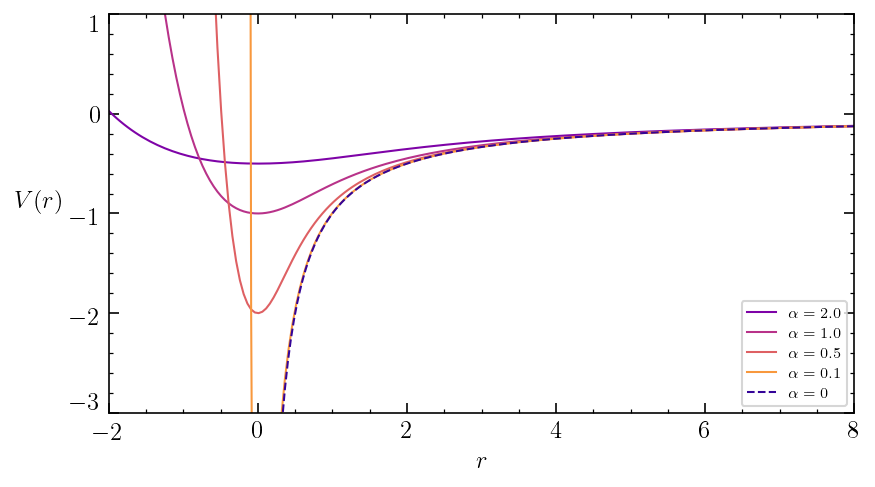

In [6]:
cols = [AmC_BRIGHT_RED, AmC_VIVID_ORANGE, AmC_BOLD_YELLOW, AmC_LIME_GREEN, AmC_DEEP_BLUE]
#ls_array = [(0, (5, 5)), (0, (3, 5, 1, 5)), (0, (3, 5, 1, 5, 1, 5)), (0, (1, 1))]

fig1 = plt.figure(dpi=148)
fig1.gca().set_xlim(-2, 8)
fig1.gca().set_ylim(-3, 1)
fig1.gca().set_yticks(np.arange(-3, 2, 1))

fig1.gca().xaxis.set_minor_locator(AutoMinorLocator())
fig1.gca().yaxis.set_minor_locator(AutoMinorLocator())

fig1.gca().tick_params(
    reset=True,
    which='both',
    direction='in',
    right = True,
    top = True
)
fig1.gca().tick_params(
    which='major',
    length=5
)


fig1.gca().set_ylabel(r"$V(r)$", rotation=0, labelpad=15)
fig1.gca().set_xlabel(r"$r$")

#fig1.gca().set_title("The Morse-soft-Coulomb potential")


rs = np.linspace(-2, 8, 200)


i=0
for alpha in [2.0, 1.0, 0.5, 0.1]:
    pots = np.array([ V(alpha, r) for r in rs ])

    fig1.gca().plot(rs, pots, markersize=0, c=Perc5[i+1], ls="solid", label=r"$\alpha = {}$".format(alpha))
    #fig1.gca().legend(loc=4)
    #fig1.legend(ncol=5)
    i += 1


coulombs = np.array([ Vc(r) for r in np.linspace(0.001, 8, 200) ])
fig1.gca().plot(np.linspace(0.001, 8, 200), coulombs, markersize=0, c=Perc5_reverse[i], ls="dashed", label=r"$\alpha = 0$")
fig1.gca().legend(loc=4)

'''
fig1.gca().get_xticklabels()[0].set_horizontalalignment("left")
fig1.gca().get_xticklabels()[-1].set_horizontalalignment("right")
'''
fig1.gca().get_yticklabels()[0].set_verticalalignment("bottom")
fig1.gca().get_yticklabels()[-1].set_verticalalignment("top")

In [18]:
figdir = "Figures/Tomada3/"

In [13]:
fig1.savefig(figdir + "Figure_1" + ".pdf", bbox_inches="tight")

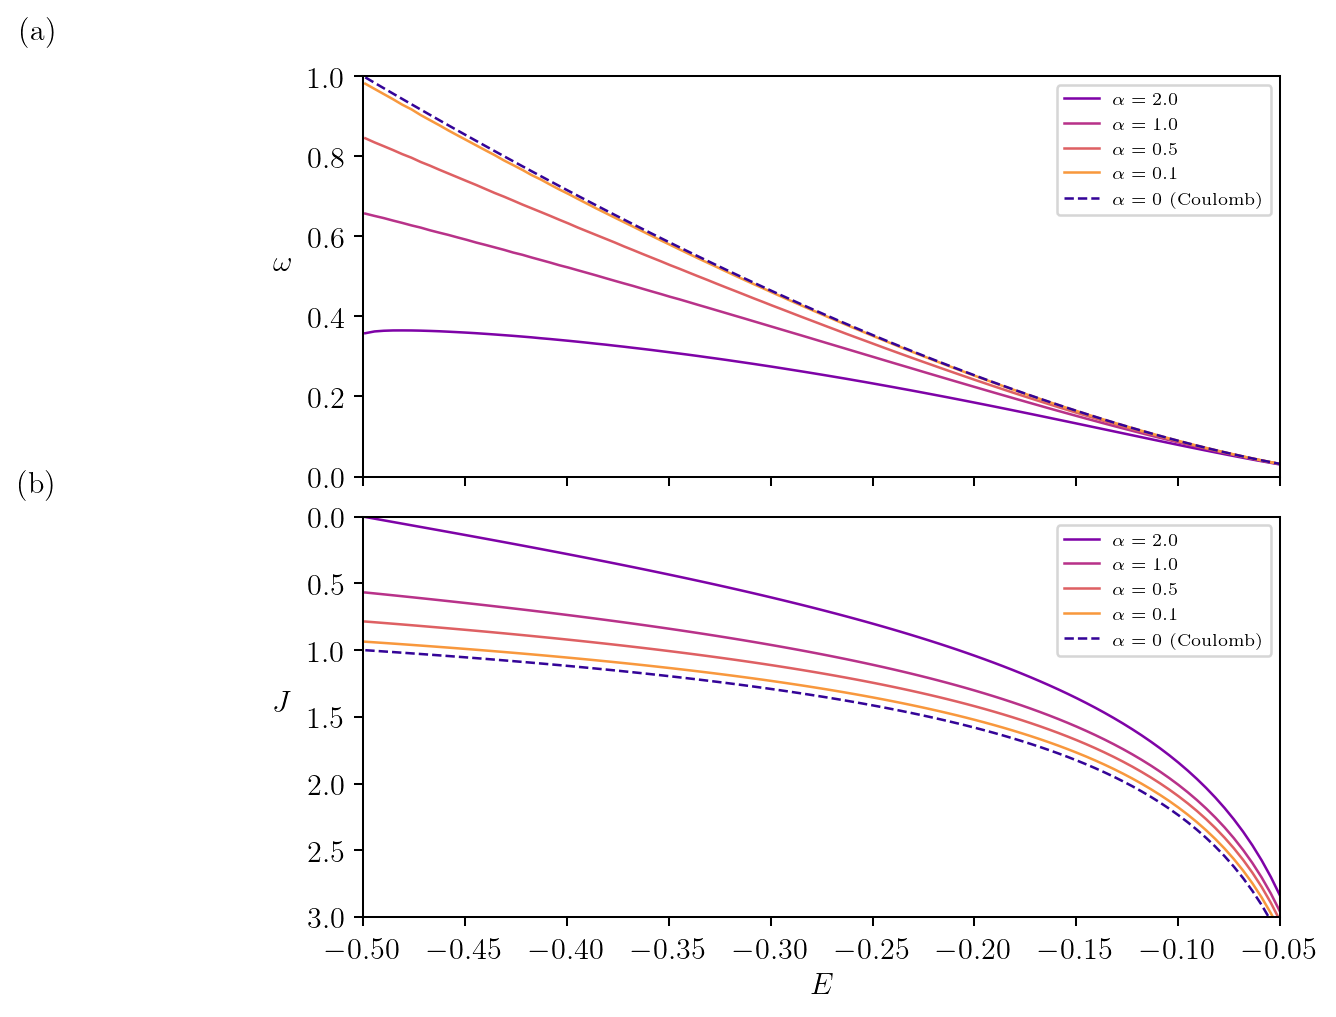

In [20]:
fig2, axs2 = plt.subplots(2, 1, sharex=True)
fig2.set_figwidth(6.5)
fig2.set_figheight(6)
fig2.set_dpi(182)
# Remove vertical spacing between subplots
plt.subplots_adjust(hspace=0.1)

fig2.gca().set_xlim( -0.5, -0.05 )
#axs2[1].set_ylim( 0, 1 )

axs2[0].set_ylim(0, 1)
axs2[1].set_ylim(0, 3)

fig2.gca().set_xlabel(r"$E$")
axs2[0].set_ylabel(r"$\omega$", rotation=0, labelpad=10)
axs2[1].set_ylabel(r"$J$", rotation=0, labelpad=10)
# Show plot
cols = [AmC_BRIGHT_RED, AmC_BOLD_YELLOW, AmC_LIGHT_GREEN, AmC_LIME_GREEN ,AmC_DEEP_BLUE]
Energies = np.linspace(-0.499, -0.05, 100)

for i, alpha in enumerate([2.0, 1.0, 0.5, 0.1, 0]):
    if alpha > 0:
        omgs = np.array([ MC_angular_frequency(alpha, E, 1.e-4) for E in Energies ])
        actions = np.array([ MC_classic_action(alpha, E, 1.e-4) for E in Energies ])

        axs2[0].plot(Energies, omgs, markersize=0, c=Perc5[i+1], label=r"$\alpha = {}$".format(alpha))
        axs2[1].plot(Energies, actions, markersize=0, c=Perc5[i+1], label=r"$\alpha = {}$".format(alpha))
    else:
        omgs = np.array([ C_angular_frequency(E) for E in Energies ])
        actions = np.array([ C_classic_action(E) for E in Energies ])

        axs2[0].plot(Energies, omgs, markersize=0, ls="dashed", c=Perc5_reverse[i], label=r"$\alpha = 0$ (Coulomb)")
        axs2[1].plot(Energies, actions, markersize=0, ls="dashed", c=Perc5_reverse[i], label=r"$\alpha = 0$ (Coulomb)")

# Add "a)" and "b)" to the top-left corners of the subplots
axs2[0].text(-0.65, max(omgs) + 0.15, '(a)', fontsize=12, verticalalignment='top', horizontalalignment='right')
#axs2[1].text(-0.53, max(actions) + 0.45, 'b)', fontsize=12, verticalalignment='top', horizontalalignment='right')
axs2[1].text(-0.65, min(actions) - 1.35, '(b)', fontsize=12, verticalalignment='top', horizontalalignment='right')

#axs2[0].legend(ncol=4)
#axs2[1].legend(ncol=4)
axs2[0].legend()
axs2[1].legend()
#fig2.legend(loc='upper center', bbox_to_anchor=(0.5, 0.03), ncol=4)

#axs2[0].set_title("Oscilating frequency and energy relation for various $\\alpha$")
#axs2[1].set_title("Classical action and energy relation for various $\\alpha$")

axs2[0].set_title("$~$")
axs2[1].set_title("$~$")

axs2[1].invert_yaxis()

(0.0, 2.0)

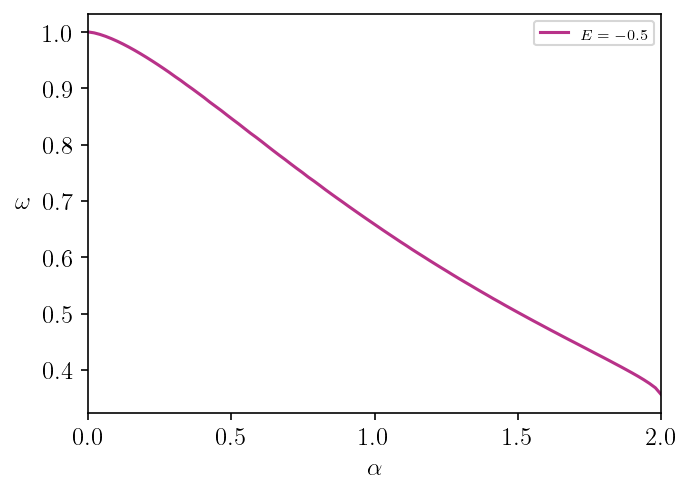

In [7]:
cols = [ AmC_DEEP_BLUE, AmC_BOLD_YELLOW, AmC_BRIGHT_RED ]

fig3 = plt.figure(dpi = 148)
#fig3.gca().set_title("Natural oscilating frequency as a function of $\\alpha$")
alphas = np.linspace(1.e-3, 1.999, 100)

omegas = np.array([ MC_angular_frequency(alpha, -0.5, 1.e-5) for alpha in alphas ])
fig3.gca().plot(alphas, omegas, markersize=0, linewidth=1.5, c=Perc5[2], label = "$E = {:.3}$".format(-0.5))


fig3.gca().legend()
fig3.gca().set_xlabel("$\\alpha$")
fig3.gca().set_ylabel("$\\omega$", rotation=0, labelpad=10)
fig3.gca().set_xlim(0, 2)
#fig3.gca().set_ylim(0, 0.2)

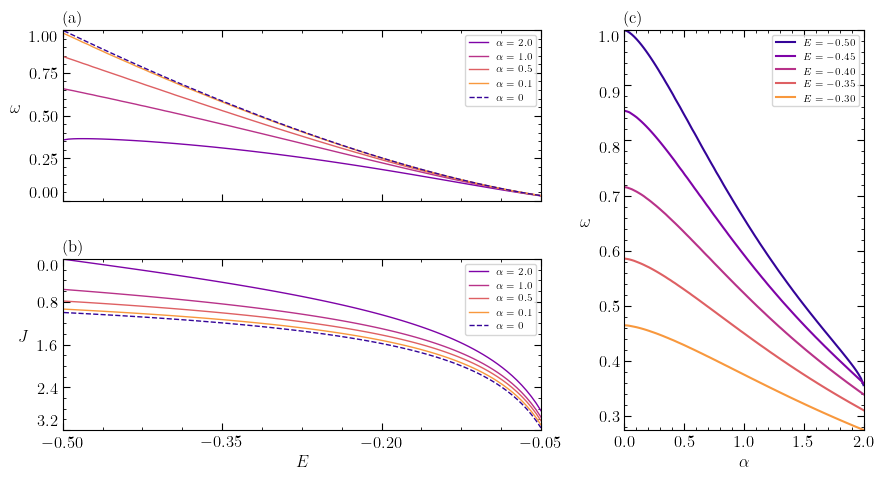

In [7]:
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib.gridspec import GridSpec
import numpy as np


# Data setup
Energies = np.linspace(-0.499, -0.05, 100)
alphas = np.linspace(1.e-3, 1.999, 100)

# Create the main figure with subplots (a) and (b)
fig = plt.figure(figsize=(9, 6))
gs = GridSpec(3, 2, height_ratios=[1, 1, 0.5], width_ratios=[1, 0.5], figure=fig)
#plt.subplots_adjust(hspace=-0.1)  # Smaller value reduces the gap; larger value increases it.


ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("(a)", loc='left', fontweight='bold')
ax1.set_xticks( np.arange(-0.5, 0, 0.15) )
ax1.set_yticks( np.arange(0, 1.25, 0.25) )
ax1.set_ylim(0, 1)
ax1.set_xlim(-0.5, -0.05)
ax1.tick_params(labelbottom=False)
ax1.tick_params(
    which='both',
    direction='in',
    right = True,
    top = True
)
ax1.tick_params(
    which='major',
    length=5
)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())

ax1.get_yticklabels()[0].set_verticalalignment("bottom")
ax1.get_yticklabels()[-1].set_verticalalignment("top")

ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
ax2.set_title("(b)", loc='left', fontweight='bold')
ax2.set_xticks( np.arange(-0.5, 0, 0.15) )
ax2.set_yticks( np.arange(0., 4, 0.8) )
ax2.set_ylim(0, 3.2)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())

ax2.tick_params(
    which='both',
    direction='in',
    right = True,
    top = True
)
ax2.tick_params(
    which='major',
    length=5
)

ax2.get_yticklabels()[0].set_verticalalignment("top")
ax2.get_yticklabels()[-1].set_verticalalignment("bottom")

ax3 = fig.add_subplot(gs[0:2, 1])
ax3.set_title("(c)", loc='left', fontweight='bold')
ax3.set_xlim(0, 2)

ax3.tick_params(
    which='both',
    direction='in',
    right = True,
    top = True
)
ax3.tick_params(
    which='major',
    length=5
)

ax3.get_yticklabels()[0].set_verticalalignment("top")

# Plot data on (a) and (b)
for i, alpha in enumerate([2.0, 1.0, 0.5, 0.1, 0]):
    if alpha > 0:
        omgs = np.array([MC_angular_frequency(alpha, E, 1.e-4) for E in Energies])
        actions = np.array([MC_classic_action(alpha, E, 1.e-4) for E in Energies])

        ax1.plot(Energies, omgs, markersize=0, c=Perc5[i+1], label=f"$\\alpha = {alpha}$")
        ax2.plot(Energies, actions, markersize=0, c=Perc5[i+1], label=f"$\\alpha = {alpha}$")
    else:
        omgs = np.array([C_angular_frequency(E) for E in Energies])
        actions = np.array([C_classic_action(E) for E in Energies])

        ax1.plot(Energies, omgs, markersize=0, ls="dashed", c=Perc5_reverse[i], label="$\\alpha = 0$")
        ax2.plot(Energies, actions, markersize=0, ls="dashed", c=Perc5_reverse[i], label="$\\alpha = 0$")

# Add legends
ax1.legend()
ax2.legend()

# Labels
ax1.set_ylabel("$\\omega$", rotation=0, labelpad=10)
ax2.set_xlabel("$E$")
ax2.set_ylabel("$J$", rotation=0, labelpad=10)
ax2.invert_yaxis()

# Add text annotations for (a) and (b)
#ax1.text(-0.5, 1.05, '(a)', fontsize=12, verticalalignment='top', horizontalalignment='right')
#ax2.text(-0.5, 3.15, '(b)', fontsize=12, verticalalignment='top', horizontalalignment='right')

# Plot data on (c)

for i, E in enumerate([Balmer(1), -0.45, -0.4, -0.35, -0.3]):
    omegas = np.array([MC_angular_frequency(alpha, E, 1.e-5) for alpha in alphas])
    ax3.plot(alphas, omegas, markersize=0, linewidth=1.5, c=Perc5[i], label="$E = {:.2f}$".format(E))
ax3.legend()
ax3.set_xlabel("$\\alpha$")
ax3.set_ylabel("$\\omega$", rotation=0, labelpad=10)
ax3.set_ylim(omegas[-1], 1)
ax3.xaxis.set_minor_locator(AutoMinorLocator())
ax3.yaxis.set_minor_locator(AutoMinorLocator())

# Adjust layout
plt.tight_layout()
plt.show()


In [12]:
fig.savefig(figdir + "Figure_2" + ".pdf", bbox_inches="tight")

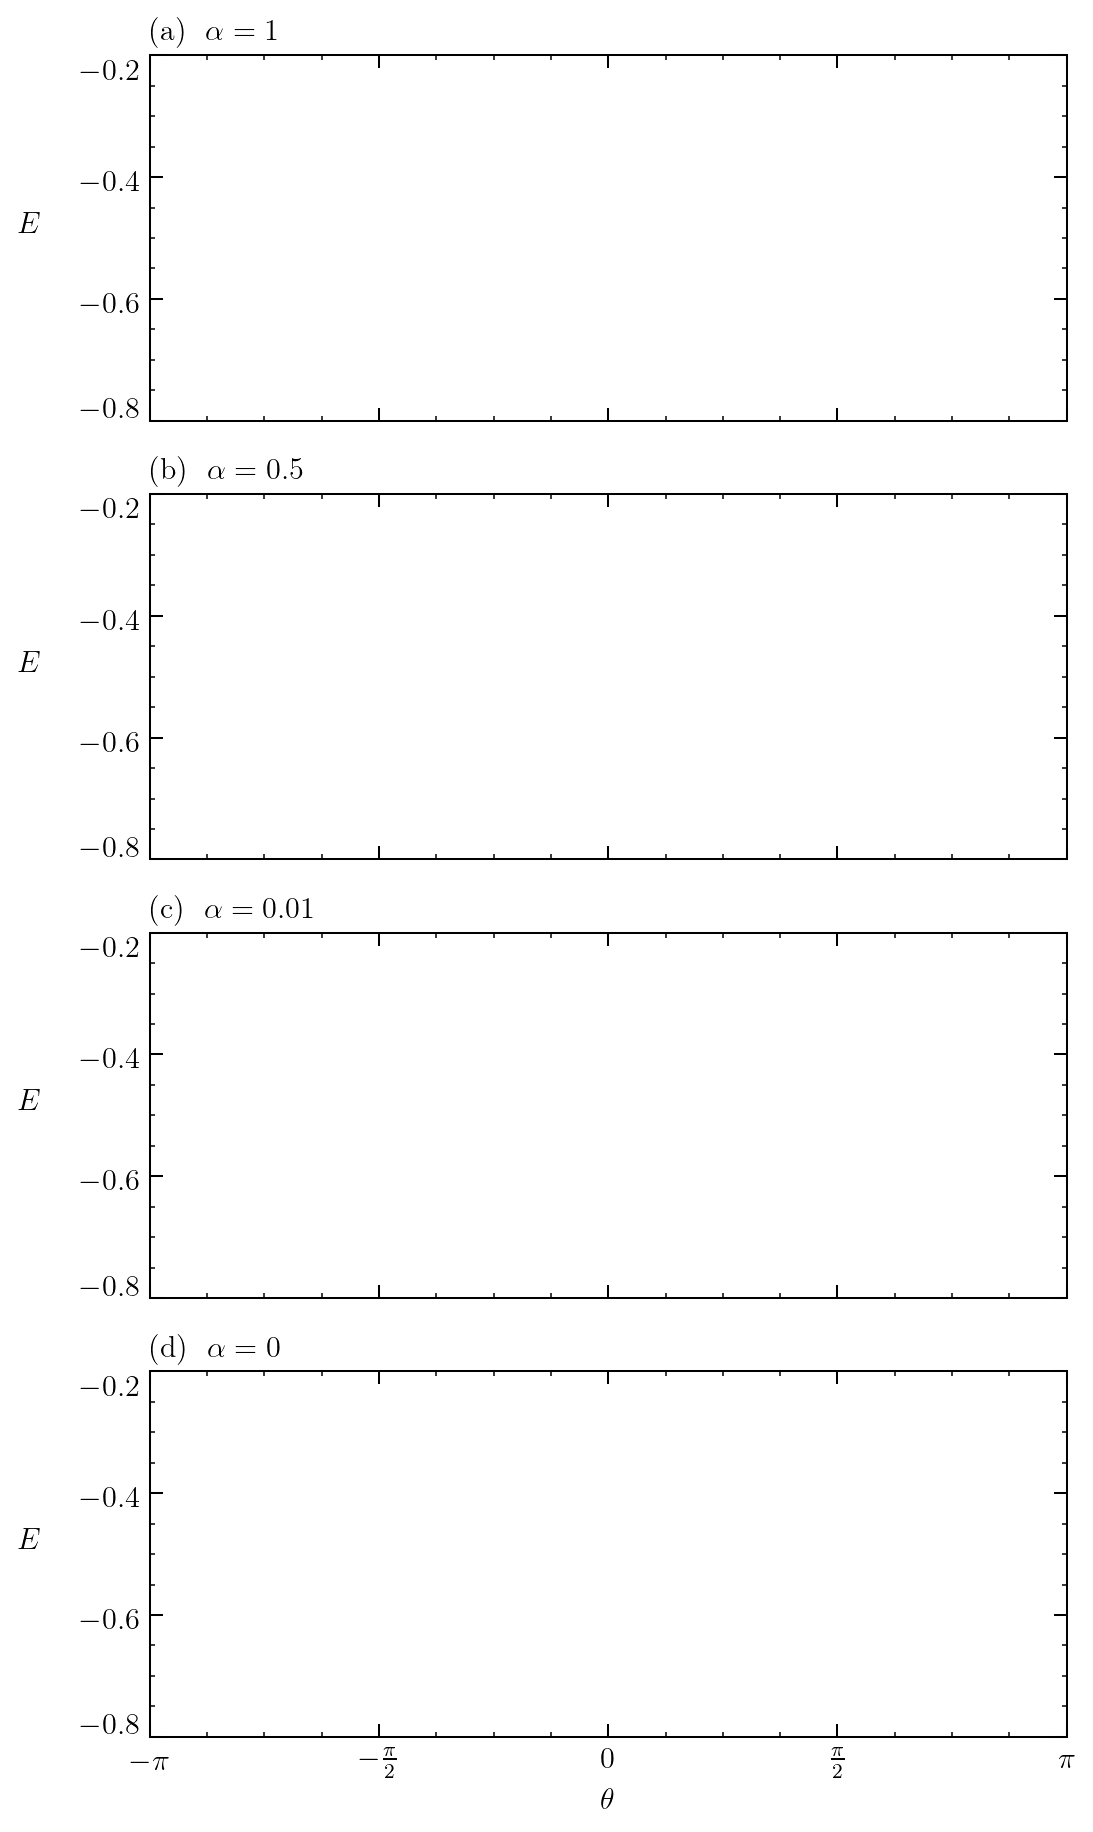

In [8]:
fig4, axs4 = plt.subplots(4, 1, sharex=True)
fig4.set_figwidth(6.5)
fig4.set_figheight(12)
fig4.set_dpi(182)
# Remove vertical spacing between subplots
plt.subplots_adjust(hspace=0.2)

titles = ["(a) $~ \\alpha = 1$", "(b) $~ \\alpha = 0.5$", "(c) $~ \\alpha = 0.01$", "(d) $~ \\alpha = 0$"]


fig4.gca().set_xlim(-np.pi, np.pi)
fig4.gca().set_xticks(np.arange(-np.pi, np.pi + np.pi/2, np.pi/2), [r"$-\pi$", r"$-\frac{\pi}{2}$", r"$0$", r"$\frac{\pi}{2}$", r"$\pi$"])
fig4.gca().set_xlabel(r"$\theta$")

for i in range(4):
    axs4[i].set_title(titles[i], loc='left', fontweight='bold')
    axs4[i].set_ylabel(r"$E$", rotation=0, labelpad=20)
    axs4[i].tick_params(which='both', direction='in', right = True, top = True)
    axs4[i].tick_params(which='major', length=5)
    axs4[i].xaxis.set_minor_locator(AutoMinorLocator())
    axs4[i].yaxis.set_minor_locator(AutoMinorLocator())
    axs4[i].set_ylim(-0.8, -0.2)
    axs4[i].set_yticks(np.arange(-0.8, 0, 0.2))
    axs4[i].get_yticklabels()[0].set_verticalalignment("bottom")
    axs4[i].get_yticklabels()[-1].set_verticalalignment("top")


# Show plot
plt.show()

['../Code/Results/PhaseSpace/Tomada7/22-12-2024--04-38-Morse-CoulombAngleEnergies.json', '../Code/Results/PhaseSpace/Tomada7/23-12-2024--20-09-Morse-CoulombAngleEnergies.json', '../Code/Results/PhaseSpace/Tomada7/25-12-2024--10-38-Morse-CoulombAngleEnergies.json', '../Code/Results/PhaseSpace/Tomada7/25-12-2024--23-43-CoulombAngleEnergies.json']


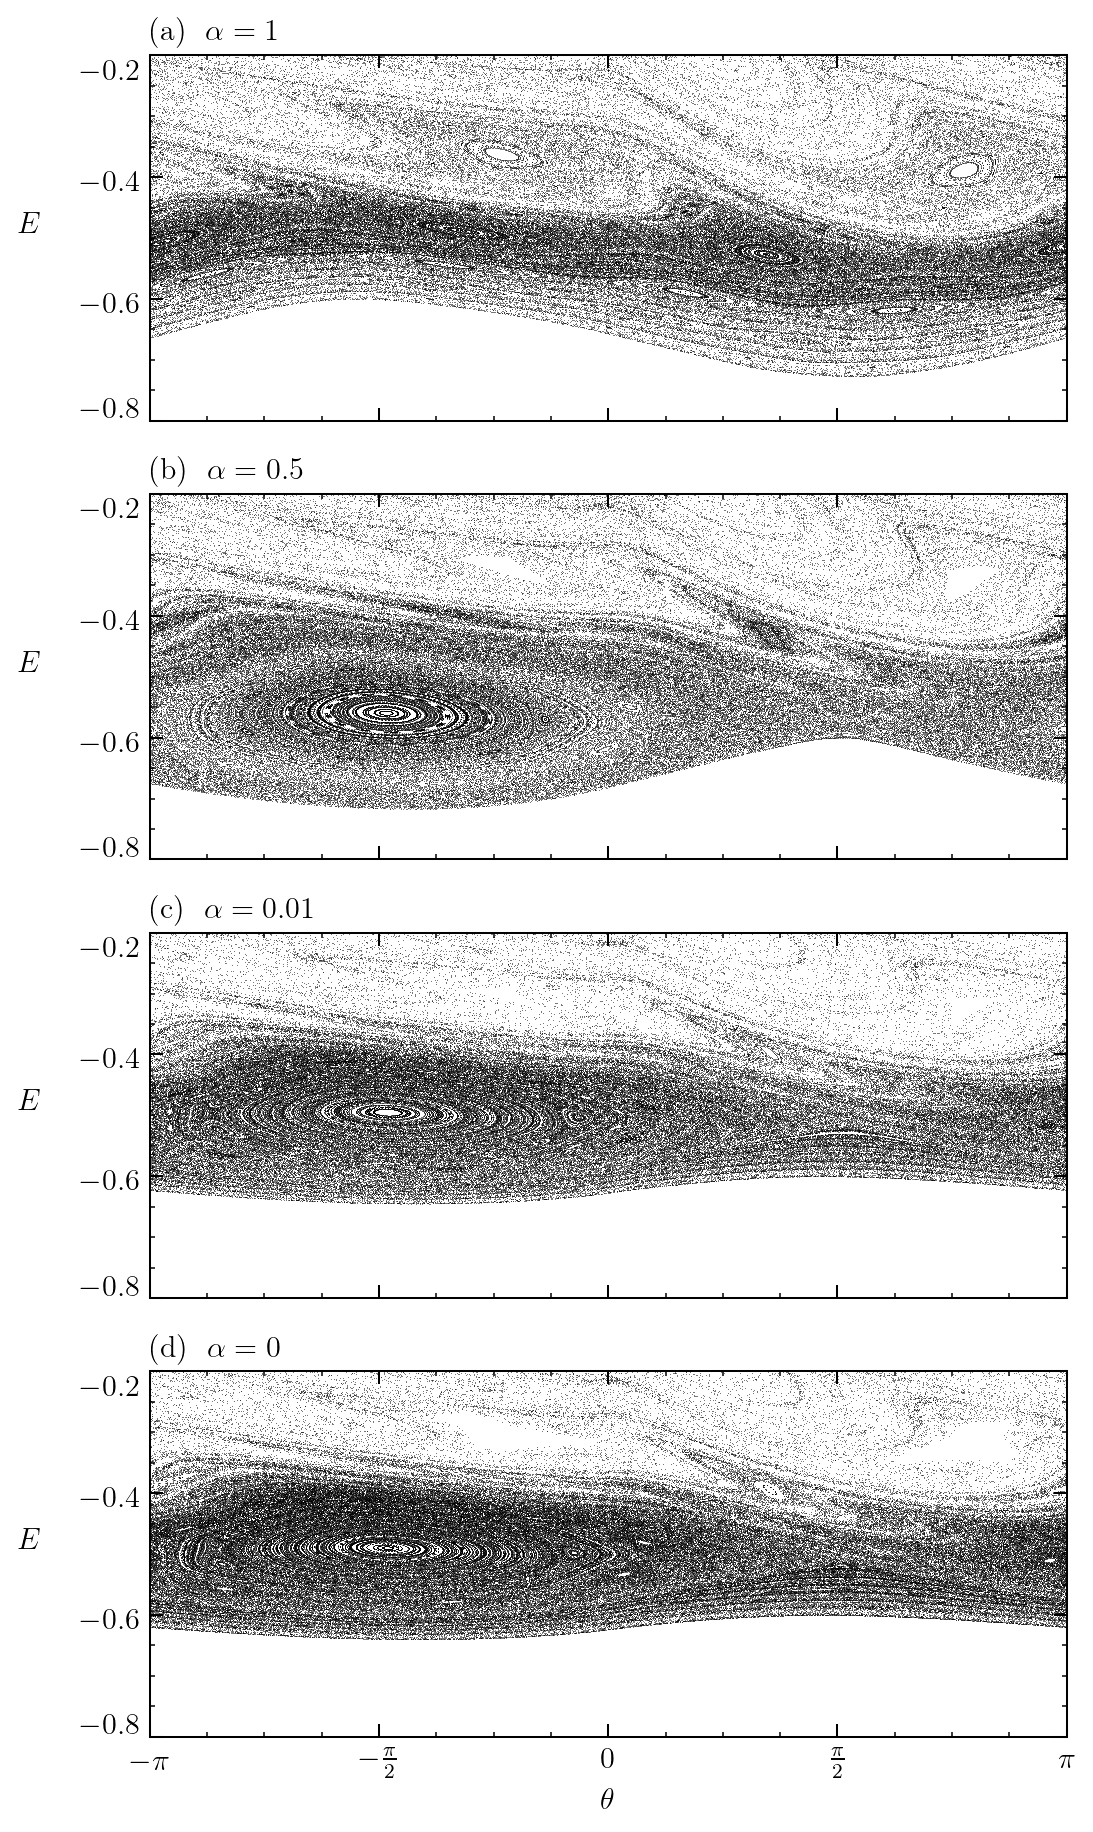

In [9]:
folder_path = results_path + "PhaseSpace/Tomada7"

# Get list of all files and directories
all_items = os.listdir(folder_path)

# Filter out only files
files = [os.path.join(folder_path, f) for f in all_items if os.path.isfile(os.path.join(folder_path, f))]

print(files)

for i in range(3):
    data = json.load( open(files[i], "r") )

    plotable = data["data"]
    alpha = data["Alpha"]
    section = np.array(data["data"])


    #axs[0].set_ylim(-0.3, -0.24)
    #axs4[i].set_title(r"Poincaré map $\theta \times E$ for $\alpha = {}$".format(alpha))
    axs4[i].scatter( section[:, 0], section[:, 1], s=0.25, marker=".", lw=0, c="black", rasterized=True )

data = json.load( open(files[3], "r") )

plotable = data["data"]
section = np.array(data["data"])

#axs4[3].set_title(r"Poincaré map $\theta \times E$ for $\alpha = 0$ (Coulomb)")
axs4[3].scatter( section[:, 0], section[:, 1], s=0.25, marker=".", lw=0, c="black", rasterized=True )
fig4

In [10]:
figdir = "Figures/take6/"

In [11]:
fig4.savefig(figdir + "Figure_4" + ".pdf", bbox_inches="tight", dpi=600)

['../Code/Results/PhaseSpace/Tomada4/07-11-2024--22-43-Morse-CoulombAngleEnergies.json', '../Code/Results/PhaseSpace/Tomada4/08-11-2024--06-16-Morse-CoulombAngleEnergies.json', '../Code/Results/PhaseSpace/Tomada4/08-11-2024--13-54-Morse-CoulombAngleEnergies.json', '../Code/Results/PhaseSpace/Tomada4/10-08-2024--12-33-CoulombAngleEnergies.json']


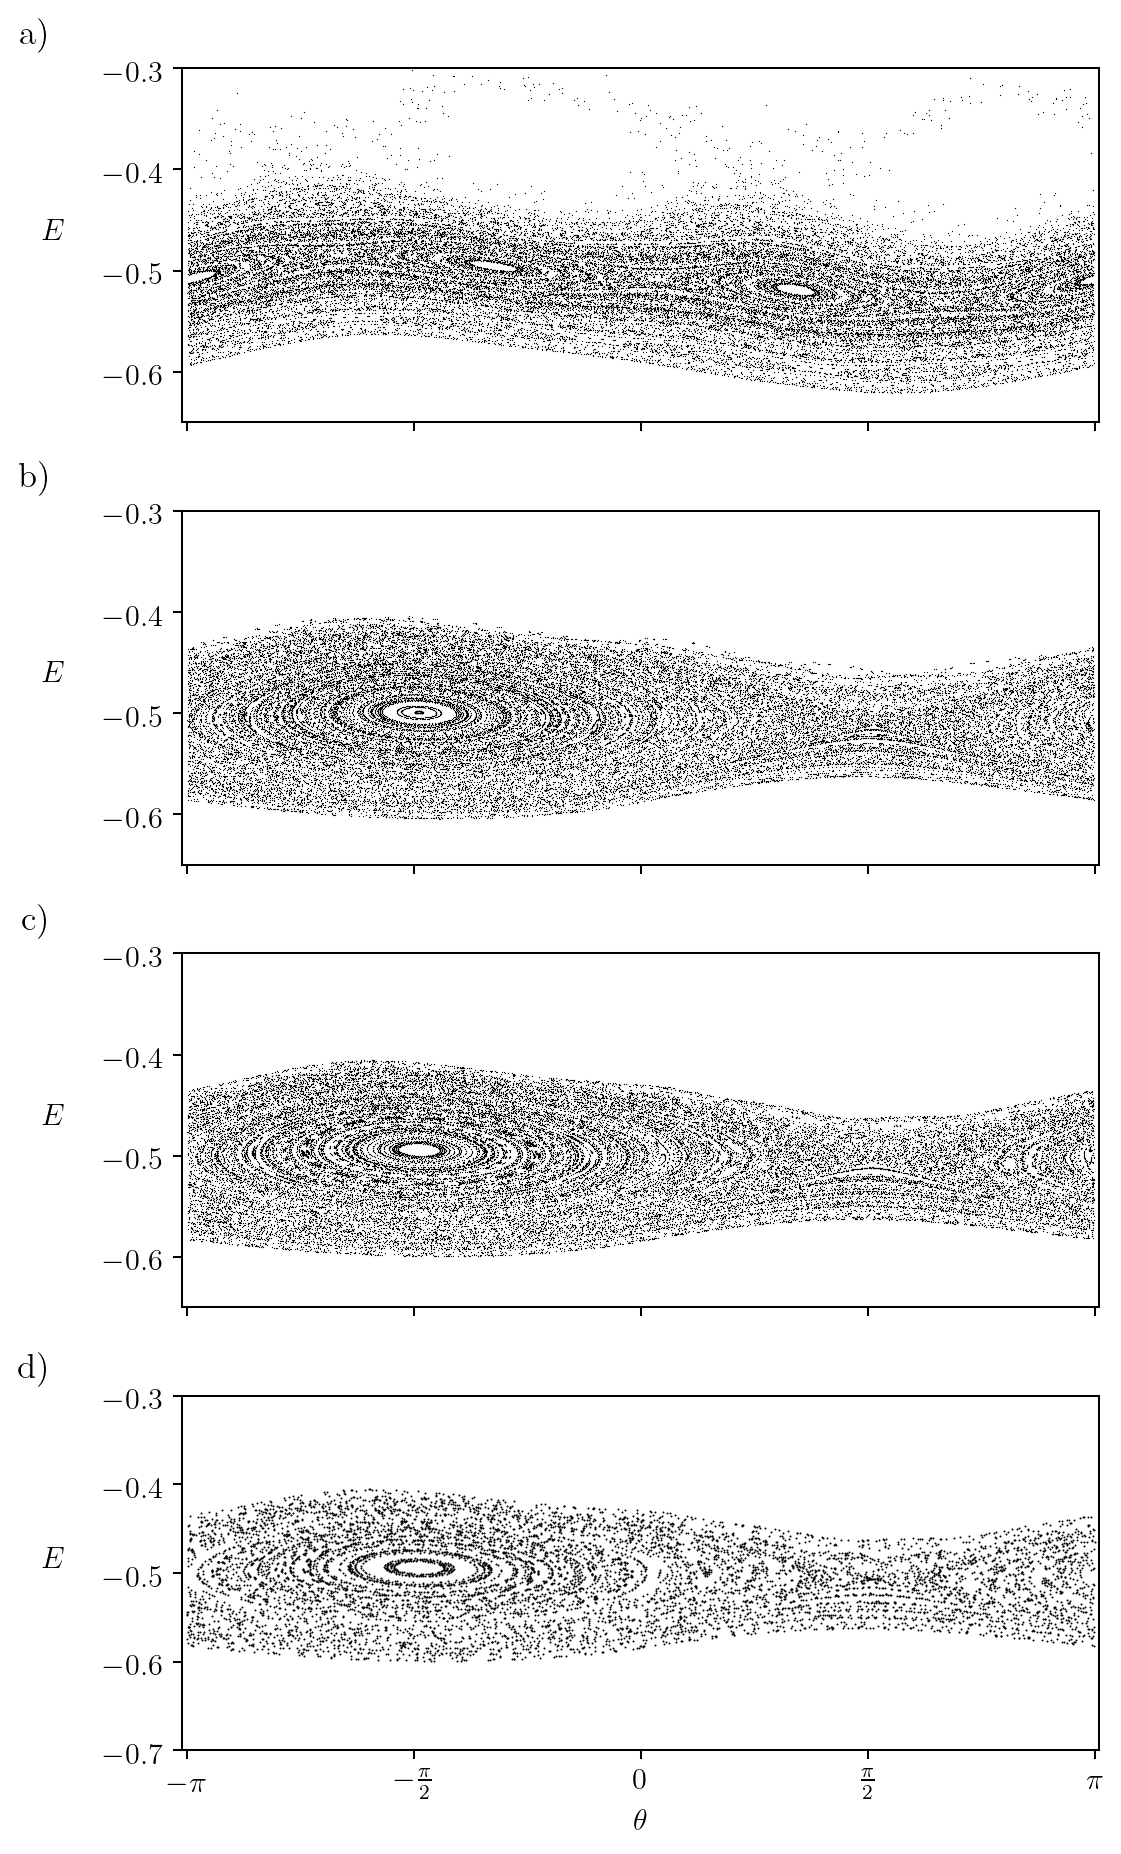

In [18]:
folder_path = results_path + "PhaseSpace/Tomada4"

# Get list of all files and directories
all_items = os.listdir(folder_path)

# Filter out only files
files = [os.path.join(folder_path, f) for f in all_items if os.path.isfile(os.path.join(folder_path, f))]

print(files)

for i in range(3):
    data = json.load( open(files[i], "r") )

    plotable = data["data"]
    alpha = data["Alpha"]
    section = np.array(data["data"])


    #axs[0].set_ylim(-0.3, -0.24)
    axs4[i].set_ylim(-0.65, -0.3)
    #axs4[i].set_title(r"Poincaré map $\theta \times E$ for $\alpha = {}$".format(alpha))
    axs4[i].scatter( section[::1, 0], section[::1, 1], s=1, marker=".", lw=0, c="black" )

data = json.load( open(files[3], "r") )

plotable = data["data"]
section = np.array(data["data"])


axs4[3].set_ylim(-0.7, -0.3)
#axs4[3].set_title(r"Poincaré map $\theta \times E$ for $\alpha = 0$ (Coulomb)")
axs4[3].scatter( section[:, 0], section[:, 1], s=2.5, marker=".", lw=0, c="black" )
fig4

In [19]:
fig4.savefig(figdir + "Figure_1_v2" + ".pdf", bbox_inches="tight")

['../Code/Results/PhaseSpace/Tomada5/08-11-2024--07-49-Morse-CoulombAngleEnergies.json', '../Code/Results/PhaseSpace/Tomada5/08-11-2024--20-15-Morse-CoulombAngleEnergies.json', '../Code/Results/PhaseSpace/Tomada5/09-11-2024--07-22-Morse-CoulombAngleEnergies.json', '../Code/Results/PhaseSpace/Tomada5/10-08-2024--12-33-CoulombAngleEnergies.json']


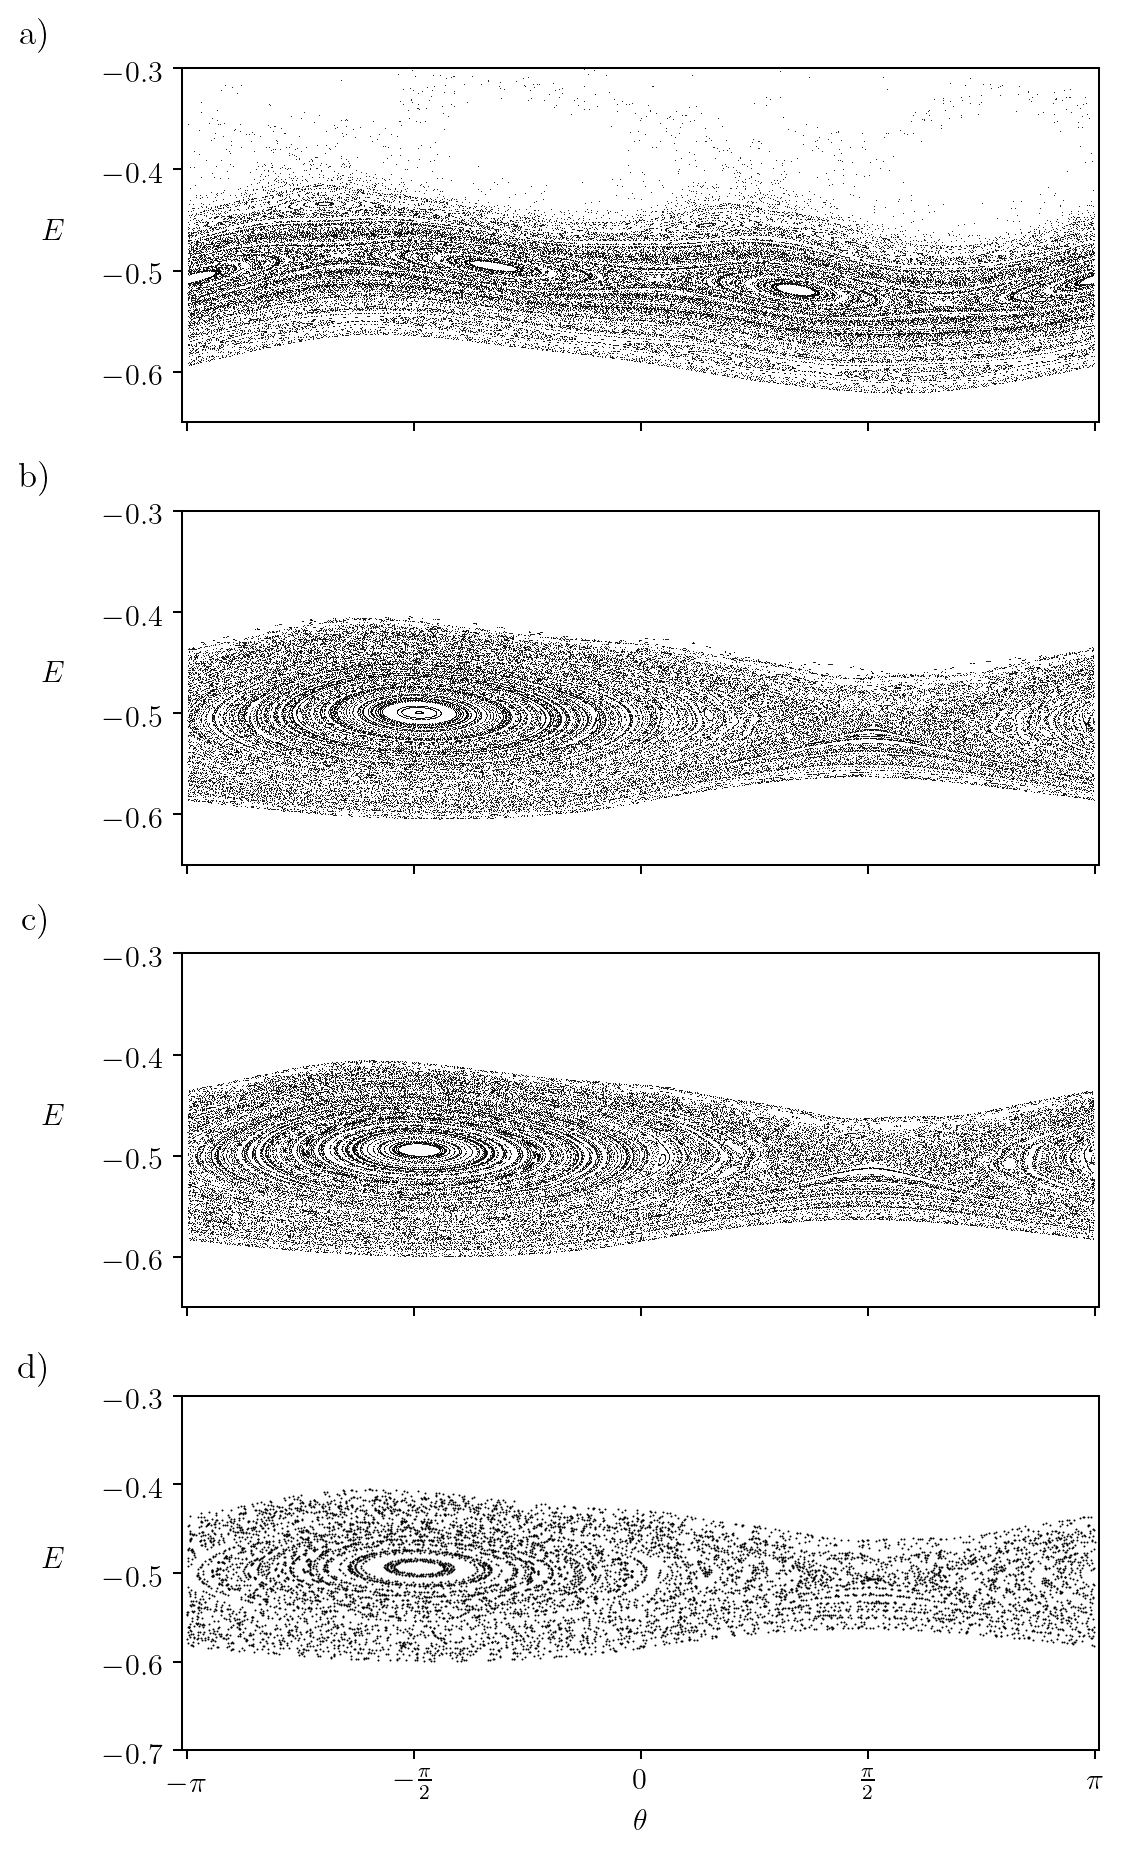

In [21]:
folder_path = results_path + "PhaseSpace/Tomada5"

# Get list of all files and directories
all_items = os.listdir(folder_path)

# Filter out only files
files = [os.path.join(folder_path, f) for f in all_items if os.path.isfile(os.path.join(folder_path, f))]

print(files)

for i in range(3):
    data = json.load( open(files[i], "r") )

    plotable = data["data"]
    alpha = data["Alpha"]
    section = np.array(data["data"])


    #axs[0].set_ylim(-0.3, -0.24)
    axs4[i].set_ylim(-0.65, -0.3)
    #axs4[i].set_title(r"Poincaré map $\theta \times E$ for $\alpha = {}$".format(alpha))
    axs4[i].scatter( section[::1, 0], section[::1, 1], s=0.5, marker=".", lw=0, c="black" )

data = json.load( open(files[3], "r") )

plotable = data["data"]
section = np.array(data["data"])


axs4[3].set_ylim(-0.7, -0.3)
#axs4[3].set_title(r"Poincaré map $\theta \times E$ for $\alpha = 0$ (Coulomb)")
axs4[3].scatter( section[:, 0], section[:, 1], s=2.5, marker=".", lw=0, c="black" )
fig4

In [22]:
fig4.savefig(figdir + "Figure_1_v3" + ".pdf", bbox_inches="tight")

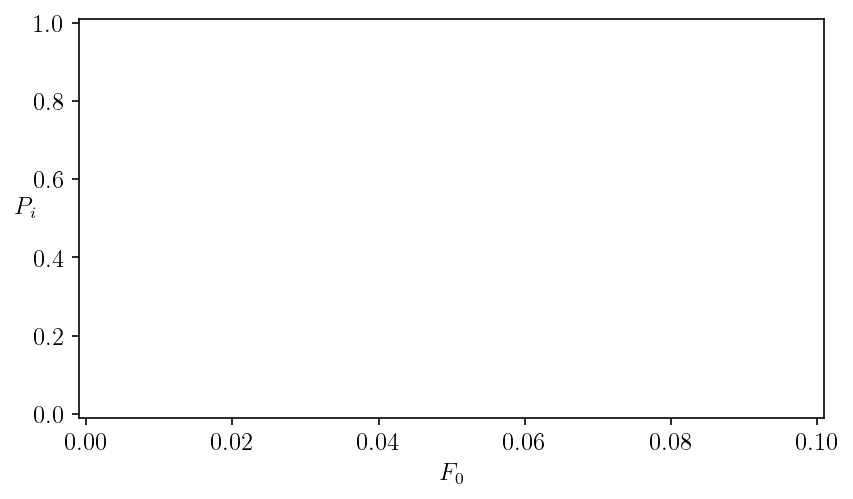

In [50]:
F0s = np.arange(0, 0.105, 0.005)

fig5 = plt.figure(dpi=148)
#fig5.gca().set_title("Ionization probability and amplitude relation for various $\\alpha$")
fig5.gca().set_xlabel( r"$F_0$" )
fig5.gca().set_ylabel( r"$P_i$", rotation=0 )
fig5.gca().set_xlim( -0.001, 0.101 )
fig5.gca().set_ylim( -0.01, 1.01 )
fig5.gca().set_xticks( np.arange(0.0, 0.12, 0.02) )

In [44]:
folder_path = results_path + 'ProbabilityXAmplitude/Tomada1'

# Get list of all files and directories
all_items = os.listdir(folder_path)

# Filter out only files
files = [os.path.join(folder_path, f) for f in all_items if os.path.isfile(os.path.join(folder_path, f))]

print(files)


['../Code/Results/ProbabilityXAmplitude/Tomada1/25-06-2024--16-56-Morse-Coulomb-ionizationNumba-Amplitude.json', '../Code/Results/ProbabilityXAmplitude/Tomada1/25-06-2024--18-22-Morse-Coulomb-ionizationNumba-Amplitude.json', '../Code/Results/ProbabilityXAmplitude/Tomada1/25-06-2024--19-55-Morse-Coulomb-ionizationNumba-Amplitude.json', '../Code/Results/ProbabilityXAmplitude/Tomada1/27-06-2024--03-01-Morse-Coulomb-ionizationNumba-Amplitude.json', '../Code/Results/ProbabilityXAmplitude/Tomada1/27-06-2024--06-09-Coulomb-ionizationNumba-Amplitude.json']


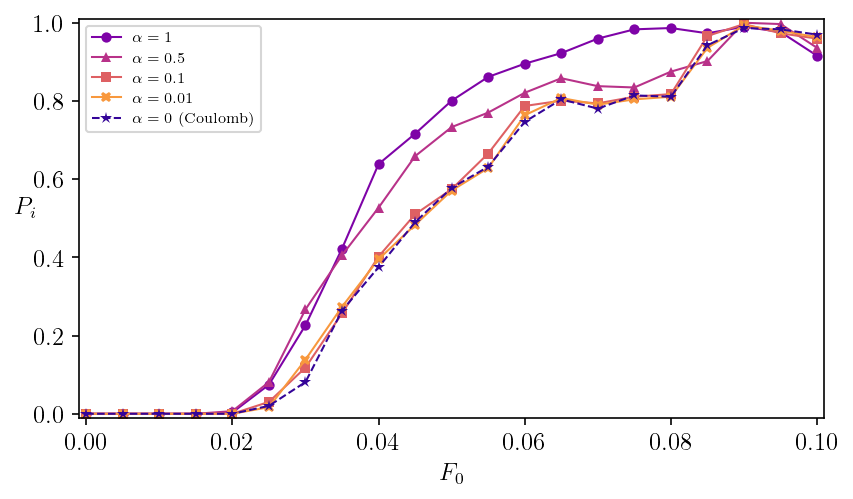

In [51]:
cols = [AmC_BRIGHT_RED, AmC_VIVID_ORANGE, AmC_BOLD_YELLOW, AmC_LIME_GREEN, AmC_DEEP_BLUE]
markers = [ "o", "^", "s", "X", "*" ]
for i, f in enumerate(files):

    with open( f, "r" ) as filehandle:
        data = json.load(filehandle)

    plotable = data["data"]
    alpha = data["Alpha"]

    Pis = list(plotable.values())

    if alpha > 0:
        fig5.gca().plot( F0s, Pis, label=r"$\alpha = {}$".format(alpha), marker=markers[i], color=Perc5[i+1], markersize=5 )
    else:
        fig5.gca().plot( F0s, Pis, label=r"$\alpha = 0$ (Coulomb)", marker=markers[i], color=Perc5_reverse[i], markersize=6, ls="dashed" )
         
    fig5.gca().legend(loc=2)
    i += 1

fig5

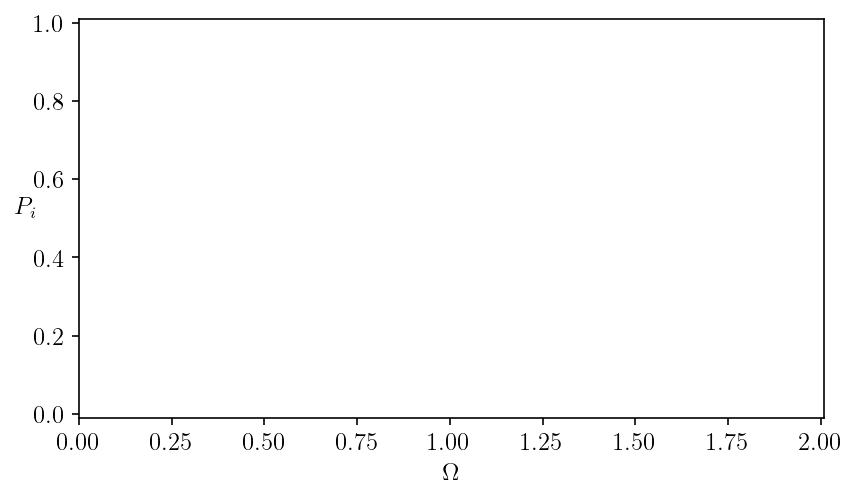

In [85]:
Omgs = np.arange(0.05, 2.1, 0.05)

fig6 = plt.figure(dpi=148)
#fig6.gca().set_title("Ionization probability and frequency relation for various $\\alpha$")
fig6.gca().set_xlabel( r"$\Omega$" )
fig6.gca().set_ylabel( r"$P_i$", rotation=0 )
fig6.gca().set_xlim( 0, 2.01 )
fig6.gca().set_ylim( -0.01, 1.01 )
fig6.gca().set_xticks( np.arange(0.0, 2.1, 0.25) )

In [71]:
folder_path = results_path + 'ProbabilityXFrequency/Tomada1'

# Get list of all files and directories
all_items = os.listdir(folder_path)

# Filter out only files
files = [os.path.join(folder_path, f) for f in all_items if os.path.isfile(os.path.join(folder_path, f))]

print(files)


['../Code/Results/ProbabilityXFrequency/Tomada1/01-08-2024--10-34-Coulomb-ionizationNumba-Frequency.json', '../Code/Results/ProbabilityXFrequency/Tomada1/26-07-2024--15-01-Morse-Coulomb-ionizationNumba-Frequency.json', '../Code/Results/ProbabilityXFrequency/Tomada1/26-07-2024--17-11-Morse-Coulomb-ionizationNumba-Frequency.json', '../Code/Results/ProbabilityXFrequency/Tomada1/26-07-2024--18-11-Morse-Coulomb-ionizationNumba-Frequency.json', '../Code/Results/ProbabilityXFrequency/Tomada1/26-07-2024--19-11-Morse-Coulomb-ionizationNumba-Frequency.json', '../Code/Results/ProbabilityXFrequency/Tomada1/29-07-2024--21-51-Morse-Coulomb-ionizationNumba-Frequency.json']


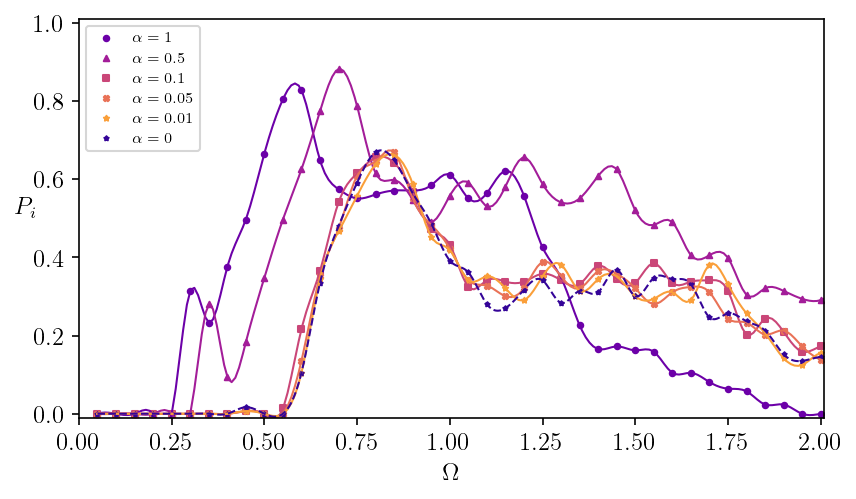

In [86]:
from scipy.interpolate import CubicSpline
markers = [ "o", "^", "s", "X", "*" ]
i = 1
cols = ['#1d65c9', '#ff1a1a', '#ff6a00', '#ffd500', '#bfe500', '#7ee236']
for f in files[1:]:

    with open( f, "r" ) as filehandle:
        data = json.load(filehandle)

    plotable = data["data"]
    alpha = data["Alpha"]

    Pis = list(plotable.values())

    spln = CubicSpline(Omgs, Pis)

    x_new = np.linspace(Omgs[0], Omgs[-1], 200)
    y_new = spln(x_new)

    #alphas.append(alpha)
    #Pis.append(plotable["0.06"])

    fig6.gca().scatter( Omgs, Pis, label=r"$\alpha = {}$".format(alpha), marker=markers[i-1], color=Perc7[i], s=7 )
    fig6.gca().plot( x_new, y_new, color=Perc7[i], markersize=0 )
    fig6.gca().legend(loc=2)
    i += 1

with open( files[0], "r" ) as filehandle:
        data = json.load(filehandle)

plotable = data["data"]
alpha = data["Alpha"]

Pis = list(plotable.values())
spln = CubicSpline(Omgs, Pis)

x_new = np.linspace(Omgs[0], Omgs[-1], 500)
y_new = spln(x_new)

#alphas.append(alpha)
#Pis.append(plotable["0.06"])
fig6.gca().scatter( Omgs, Pis, label="$\\alpha = 0$", marker=markers[4], color=Perc5[0], s=5 )
fig6.gca().plot( x_new, y_new, color=Perc5[0], markersize=0, ls="dashed" )
fig6.gca().legend(loc=2)

fig6

['../Code/Results/ProbabilityXFrequency/Tomada1/01-08-2024--10-34-Coulomb-ionizationNumba-Frequency.json', '../Code/Results/ProbabilityXFrequency/Tomada1/26-07-2024--15-01-Morse-Coulomb-ionizationNumba-Frequency.json', '../Code/Results/ProbabilityXFrequency/Tomada1/26-07-2024--17-11-Morse-Coulomb-ionizationNumba-Frequency.json', '../Code/Results/ProbabilityXFrequency/Tomada1/26-07-2024--18-11-Morse-Coulomb-ionizationNumba-Frequency.json', '../Code/Results/ProbabilityXFrequency/Tomada1/29-07-2024--21-51-Morse-Coulomb-ionizationNumba-Frequency.json']


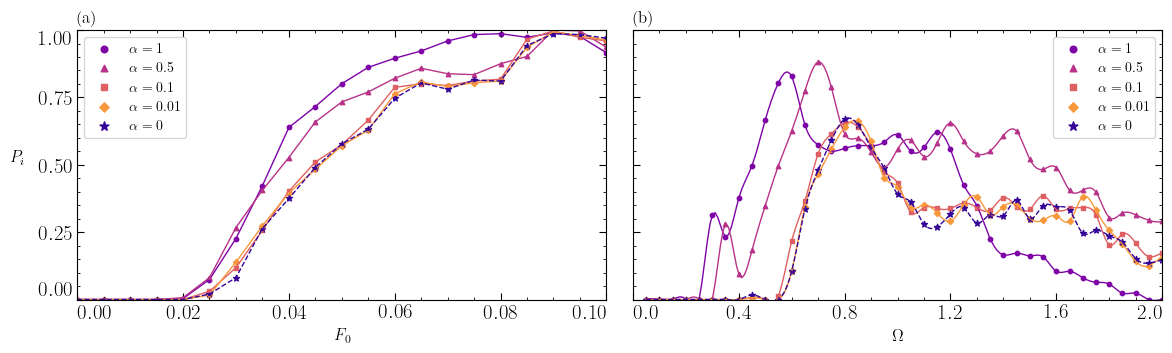

In [28]:
from scipy.interpolate import CubicSpline

figPi, axsPi = plt.subplots(1, 2, sharey=True)

figPi.set_figwidth(14)

F0s = np.arange(0, 0.105, 0.005)
Omgs = np.arange(0.05, 2.1, 0.05)
markers = [ "o", "^", "s", "D", "*" ]

plt.subplots_adjust(wspace=0.05)  # Adjust wspace to control horizontal spacing

#fig5.gca().set_title("Ionization probability and amplitude relation for various $\\alpha$")
axsPi[0].set_title("(a)", loc='left', fontweight='bold')
axsPi[0].set_xlabel( r"$F_0$" )
axsPi[0].set_ylabel( r"$P_i$", rotation=0, labelpad=15 )
axsPi[0].set_xlim( 0, 0.1 )
axsPi[0].set_ylim( 0, 1 )
axsPi[0].set_xticks( np.arange(0.0, 0.12, 0.02) )
axsPi[0].xaxis.set_minor_locator(AutoMinorLocator())
axsPi[0].yaxis.set_minor_locator(AutoMinorLocator())

folder_path = results_path + 'ProbabilityXAmplitude/Tomada1'

# Get list of all files and directories
all_items = os.listdir(folder_path)

# Filter out only files
files = [os.path.join(folder_path, f) for f in all_items if os.path.isfile(os.path.join(folder_path, f))]

for i, f in enumerate(files):

    with open( f, "r" ) as filehandle:
        data = json.load(filehandle)

    plotable = data["data"]
    alpha = data["Alpha"]

    Pis = list(plotable.values())

    if alpha > 0:
        axsPi[0].plot( F0s, Pis, color=Perc5[i+1])
        axsPi[0].scatter( F0s, Pis, label=r"$\alpha = {}$".format(alpha), marker=markers[i], color=Perc5[i+1], s=10 )
    else:
        axsPi[0].plot( F0s, Pis, color=Perc5_reverse[i], ls="dashed" )
        axsPi[0].scatter( F0s, Pis, label=r"$\alpha = 0$", marker=markers[i], color=Perc5_reverse[i], s=20 )
        
         
    axsPi[0].legend(loc=2, fontsize=10, markerscale=1.5)
    i += 1

axsPi[1].set_title("(b)", loc='left', fontweight='bold')
axsPi[1].set_xlabel( r"$\Omega$" )
#axsPi[1].set_ylabel( r"$P_i$", rotation=0 )
axsPi[1].set_xlim( 0, 2 )
axsPi[1].set_ylim( 0, 1 )
axsPi[1].set_xticks(np.arange(0., 2.4, 0.4))
axsPi[1].set_yticks(np.arange(0., 1.25, 0.25))
axsPi[1].xaxis.set_minor_locator(AutoMinorLocator())
axsPi[1].yaxis.set_minor_locator(AutoMinorLocator())

for label in axsPi[0].get_xticklabels():
    label.set_fontsize(15)
axsPi[0].get_xticklabels()[0].set_horizontalalignment("left")
axsPi[0].get_xticklabels()[-1].set_horizontalalignment("right")

for label in axsPi[0].get_yticklabels():
    label.set_fontsize(15)
axsPi[0].get_yticklabels()[0].set_verticalalignment("bottom")
axsPi[0].get_yticklabels()[-1].set_verticalalignment("top")
     
for label in axsPi[1].get_xticklabels():
    label.set_fontsize(15)
axsPi[1].get_xticklabels()[0].set_horizontalalignment("left")
axsPi[1].get_xticklabels()[-1].set_horizontalalignment("right")


axsPi[0].tick_params(
    which='both',
    direction='in',
    right = True,
    top = True
)
axsPi[0].tick_params(
    which='major',
    length=5
)

folder_path = results_path + 'ProbabilityXFrequency/Tomada1'

# Get list of all files and directories
all_items = os.listdir(folder_path)

# Filter out only files
files = [os.path.join(folder_path, f) for f in all_items if os.path.isfile(os.path.join(folder_path, f))]

print(files)
#plt.subplots_adjust(hspace=0.1)

i = 1
for f in files[1:]:
    
    with open( f, "r" ) as filehandle:
        data = json.load(filehandle)

    plotable = data["data"]
    alpha = data["Alpha"]

    Pis = list(plotable.values())

    spln = CubicSpline(Omgs, Pis)

    x_new = np.linspace(Omgs[0], Omgs[-1], 200)
    y_new = spln(x_new)

    #alphas.append(alpha)
    #Pis.append(plotable["0.06"])

    axsPi[1].plot( x_new, y_new, color=Perc5[i], markersize=0 )
    axsPi[1].scatter( Omgs, Pis, label=r"$\alpha = {}$".format(alpha), marker=markers[i-1], color=Perc5[i], s=10 )
    i += 1


with open( files[0], "r" ) as filehandle:
        data = json.load(filehandle)

plotable = data["data"]
alpha = data["Alpha"]

Pis = list(plotable.values())
spln = CubicSpline(Omgs, Pis)

x_new = np.linspace(Omgs[0], Omgs[-1], 500)

y_new = spln(x_new)

#alphas.append(alpha)
#Pis.append(plotable["0.06"])
axsPi[1].scatter( Omgs, Pis, label="$\\alpha = 0$", marker=markers[4], color=Perc5[0], s=20 )
axsPi[1].plot( x_new, y_new, color=Perc5[0], markersize=0, ls="dashed" )
#axsPi[1].legend(loc=2)
axsPi[1].legend(loc=1, fontsize=10, markerscale=1.5)
axsPi[1].tick_params(
    which='both',
    direction='in',
    right = True,
    top = True
)
axsPi[1].tick_params(
    which='major',
    length=5
)


['../Code/Results/ProbabilityXFrequency/Tomada1/01-08-2024--10-34-Coulomb-ionizationNumba-Frequency.json', '../Code/Results/ProbabilityXFrequency/Tomada1/26-07-2024--15-01-Morse-Coulomb-ionizationNumba-Frequency.json', '../Code/Results/ProbabilityXFrequency/Tomada1/26-07-2024--17-11-Morse-Coulomb-ionizationNumba-Frequency.json', '../Code/Results/ProbabilityXFrequency/Tomada1/26-07-2024--18-11-Morse-Coulomb-ionizationNumba-Frequency.json', '../Code/Results/ProbabilityXFrequency/Tomada1/29-07-2024--21-51-Morse-Coulomb-ionizationNumba-Frequency.json']


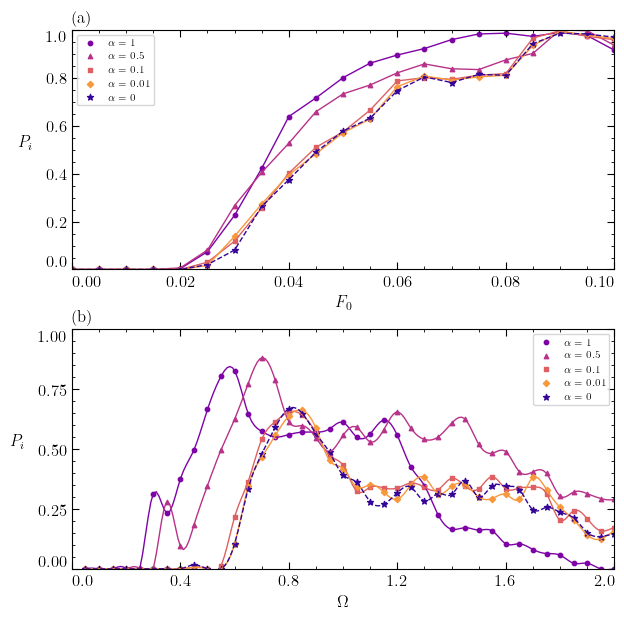

In [24]:
from scipy.interpolate import CubicSpline

figPi, axsPi = plt.subplots(2, 1)

figPi.set_figwidth(7)
figPi.set_figheight(7)

F0s = np.arange(0, 0.105, 0.005)
Omgs = np.arange(0.05, 2.1, 0.05)
markers = [ "o", "^", "s", "D", "*" ]

plt.subplots_adjust(hspace=0.25)  # Adjust wspace to control horizontal spacing

#fig5.gca().set_title("Ionization probability and amplitude relation for various $\\alpha$")
axsPi[0].set_title("(a)", loc='left', fontweight='bold')
axsPi[0].set_xlabel( r"$F_0$" )
axsPi[0].set_ylabel( r"$P_i$", rotation=0, labelpad=15 )
axsPi[0].set_xlim( 0, 0.1 )
axsPi[0].set_ylim( 0, 1 )
axsPi[0].set_xticks( np.arange(0.0, 0.12, 0.02) )
axsPi[0].xaxis.set_minor_locator(AutoMinorLocator())
axsPi[0].yaxis.set_minor_locator(AutoMinorLocator())

folder_path = results_path + 'ProbabilityXAmplitude/Tomada1'

# Get list of all files and directories
all_items = os.listdir(folder_path)

# Filter out only files
files = [os.path.join(folder_path, f) for f in all_items if os.path.isfile(os.path.join(folder_path, f))]

for i, f in enumerate(files):

    with open( f, "r" ) as filehandle:
        data = json.load(filehandle)

    plotable = data["data"]
    alpha = data["Alpha"]

    Pis = list(plotable.values())

    if alpha > 0:
        axsPi[0].plot( F0s, Pis, color=Perc5[i+1])
        axsPi[0].scatter( F0s, Pis, label=r"$\alpha = {}$".format(alpha), marker=markers[i], color=Perc5[i+1], s=10 )
    else:
        axsPi[0].plot( F0s, Pis, color=Perc5_reverse[i], ls="dashed" )
        axsPi[0].scatter( F0s, Pis, label=r"$\alpha = 0$", marker=markers[i], color=Perc5_reverse[i], s=20 )
        
         
    axsPi[0].legend(loc=2)#, fontsize=10, markerscale=1.5)
    i += 1

axsPi[1].set_title("(b)", loc='left', fontweight='bold')
axsPi[1].set_xlabel( r"$\Omega$" )
axsPi[1].set_ylabel( r"$P_i$", rotation=0, labelpad=15 )
axsPi[1].set_xlim( 0, 2 )
axsPi[1].set_ylim( 0, 1 )
axsPi[1].set_xticks(np.arange(0., 2.4, 0.4))
axsPi[1].set_yticks(np.arange(0., 1.25, 0.25))
axsPi[1].xaxis.set_minor_locator(AutoMinorLocator())
axsPi[1].yaxis.set_minor_locator(AutoMinorLocator())

#for label in axsPi[0].get_xticklabels():
    #label.set_fontsize(15)
axsPi[0].get_xticklabels()[0].set_horizontalalignment("left")
axsPi[0].get_xticklabels()[-1].set_horizontalalignment("right")

#for label in axsPi[0].get_yticklabels():
#    label.set_fontsize(15)
axsPi[0].get_yticklabels()[0].set_verticalalignment("bottom")
axsPi[0].get_yticklabels()[-1].set_verticalalignment("top")
     
#or label in axsPi[1].get_xticklabels():
#   label.set_fontsize(15)
axsPi[1].get_xticklabels()[0].set_horizontalalignment("left")
axsPi[1].get_xticklabels()[-1].set_horizontalalignment("right")

axsPi[1].get_yticklabels()[0].set_verticalalignment("bottom")
axsPi[1].get_yticklabels()[-1].set_verticalalignment("top")

axsPi[0].tick_params(
    which='both',
    direction='in',
    right = True,
    top = True
)
axsPi[0].tick_params(
    which='major',
    length=5
)

folder_path = results_path + 'ProbabilityXFrequency/Tomada1'

# Get list of all files and directories
all_items = os.listdir(folder_path)

# Filter out only files
files = [os.path.join(folder_path, f) for f in all_items if os.path.isfile(os.path.join(folder_path, f))]

print(files)
#plt.subplots_adjust(hspace=0.1)

i = 1
for f in files[1:]:
    
    with open( f, "r" ) as filehandle:
        data = json.load(filehandle)

    plotable = data["data"]
    alpha = data["Alpha"]

    Pis = list(plotable.values())

    spln = CubicSpline(Omgs, Pis)

    x_new = np.linspace(Omgs[0], Omgs[-1], 200)
    y_new = spln(x_new)

    #alphas.append(alpha)
    #Pis.append(plotable["0.06"])

    axsPi[1].plot( x_new, y_new, color=Perc5[i], markersize=0 )
    axsPi[1].scatter( Omgs, Pis, label=r"$\alpha = {}$".format(alpha), marker=markers[i-1], color=Perc5[i], s=10 )
    i += 1


with open( files[0], "r" ) as filehandle:
        data = json.load(filehandle)

plotable = data["data"]
alpha = data["Alpha"]

Pis = list(plotable.values())
spln = CubicSpline(Omgs, Pis)

x_new = np.linspace(Omgs[0], Omgs[-1], 500)

y_new = spln(x_new)

#alphas.append(alpha)
#Pis.append(plotable["0.06"])
axsPi[1].scatter( Omgs, Pis, label="$\\alpha = 0$", marker=markers[4], color=Perc5[0], s=20 )
axsPi[1].plot( x_new, y_new, color=Perc5[0], markersize=0, ls="dashed" )
#axsPi[1].legend(loc=2)
axsPi[1].legend(loc=1)#, fontsize=10, markerscale=1.5)
axsPi[1].tick_params(
    which='both',
    direction='in',
    right = True,
    top = True
)
axsPi[1].tick_params(
    which='major',
    length=5
)


In [25]:
figPi.savefig(figdir + "Figure_3" + ".pdf", bbox_inches="tight")

['../Code/Results/ProbabilityXAlpha/Tomada2\\16-08-2024--23-51-Morse-Coulomb-ionizationNumba-Alphas.json']


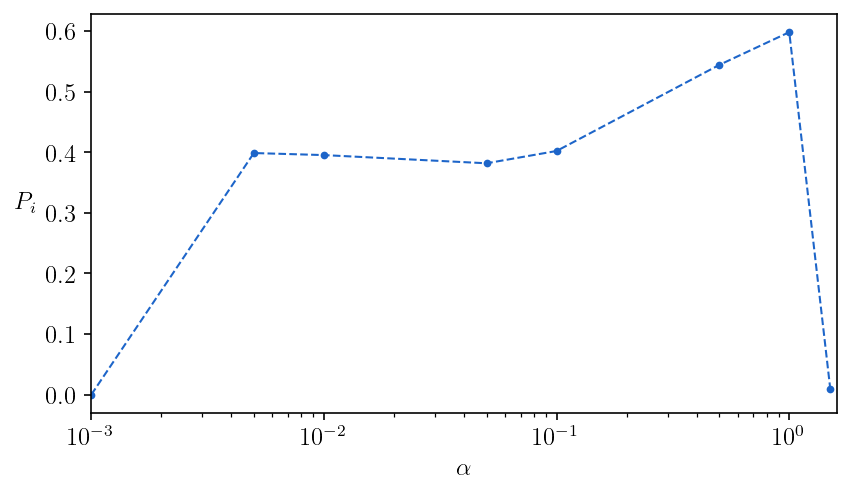

In [16]:
fig7 = plt.figure(dpi=148)
#fig7.gca().set_title("Ionization probability for various $\\alpha$")
fig7.gca().set_xlabel( r"$\alpha$" )
fig7.gca().set_ylabel( r"$P_i$", rotation=0, labelpad=10 )
fig7.gca().set_xlim( 1.e-3, 1.6 )
#fig7.gca().set_ylim( -0.01, 0.06 )
#fig4.gca().set_xticks( np.arange(0.0, 1.58, 0.3) )

folder_path = results_path + 'ProbabilityXAlpha/Tomada2'

# Get list of all files and directories
all_items = os.listdir(folder_path)

# Filter out only files
files = [os.path.join(folder_path, f) for f in all_items if os.path.isfile(os.path.join(folder_path, f))]

print(files)
data = json.load( open(files[0], "r") )
plotable = data["data"]

Pis = list(plotable.values())
Alphas = data["Alphas"]

fig7.gca().plot( Alphas[1:], Pis[1:], color=AmC_DEEP_BLUE, ls="dashed", markersize=7.5 )
fig7.gca().set_xscale('log')

In [17]:
figdir = "Figures/"

figs = [fig1, fig2, fig3, fig4, fig5, fig6, fig7]

for i, fig, in enumerate(figs):
    fig.savefig(figdir + "Figure_" + str(i+1) + ".pdf", bbox_inches="tight")

final time= 4134.137457575099 100.0
t0 parameter=  1422.970112897349
number of time steps=  826827 99.9999405541029 100.0
Posição inicial= 1.6497272501841025
Momento inicial= -0.30137976163009533
Campo em t=0 = 0.0004235925391524178
99.9999405541029

transfered Energy =  0.49209049503822777
Cost Functional=  0.0005093346852681148

Campo em t=t_f = -0.0004378048531510013
derivada do potencial em r(tf)=  6.26024410172087e-05
Posição final= 126.38377270728967
Momento final= 0.002365644743350693


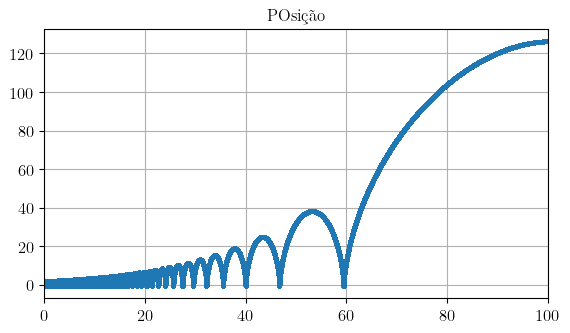

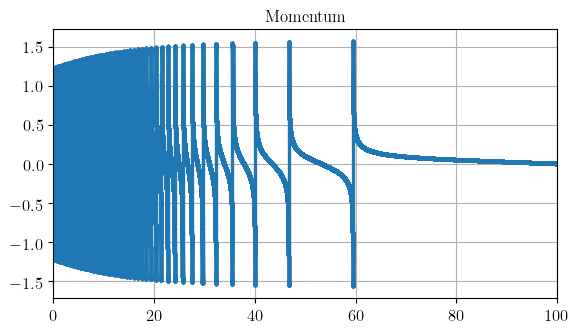

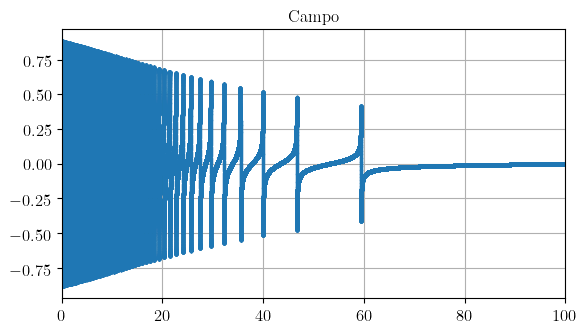

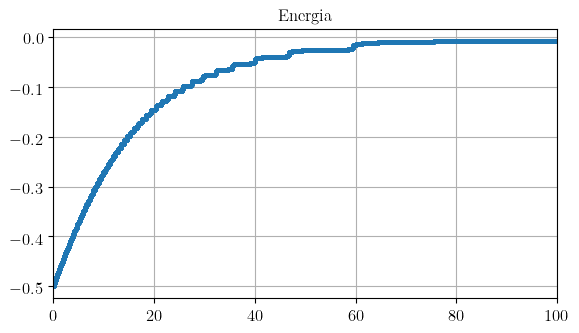

In [4]:

# -*- coding: utf-8 -*-
"""
Created on September 2024

@author: Emanuel Fernandes de Lima

Optimal solution of classical dynamics: intrinsic optimal solution

"""

import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

#parâmetros (globais) de conversão
auVm=5.14220826e2 # 1 atomic unit in 1.e9 V/m
aufts=0.02418884254 # 1 au em femtosegundos
audebye=2.541746 # 1 au in debye
aueV=27.211324570273 # 1 au in eV


# MsC softening parameter
alpha=0.8  #0.125
alphsq2=alpha*np.sqrt(2)

# Parameter for the Morse potential
q=1.
m=1.

#parameters for the calculations
t0=34.42/aufts
tf=100/aufts  #40

print("final time=",tf, tf*aufts)
print("t0 parameter= ",t0)

# Parameter for the evolution
dt=0.005
n=round(tf/dt)
time=np.zeros(n+1)

print("number of time steps= ",n,n*dt*aufts,tf*aufts)

#Position, momentum and field vectors
x=np.zeros(2)
rvec=np.zeros(n+1)
pvec=np.zeros(n+1)
uvec=np.zeros(n+1)
E0vec=np.zeros(n+1)
def V(y):
  if y>0. :
    return -1/np.sqrt(y**2+alpha**2)
  else:
    return (np.exp(-2*y/alphsq2)-2*np.exp(-y/alphsq2))/alpha

def dV(y):
  if y>0. :
    return y/(y**2+alpha**2)**(1.5)
  else:
    return (2/alpha/alphsq2)*(-np.exp(-2*y/alphsq2)+np.exp(-y/alphsq2))

def u(p,t):
  return -2*p/(q*(t+t0))

def eqdiff(t,x):
  dx=np.zeros(2)
  dx[0]=x[1]/m
  dx[1]=-dV(x[0])+2*x[1]/(t+t0)
  return dx

#Runge-Kutta
def rk4(t,x,dt):
  k1=eqdiff(t,x)
  k2=eqdiff(t+dt/2,x+dt*k1/2)
  k3=eqdiff(t+dt/2,x+dt*k2/2)
  k4=eqdiff(t+dt,x+dt*k3)
  return x+dt*(k1+2*k2+2*k3+k4)/6

# Condições iniciais
time[0]=0
Ei=-0.5# initial energy
retorn=np.sqrt(1/Ei**2-alpha**2)
x[0]=0.9*retorn
x[1]=-np.sqrt(2*(Ei-V(x[0]))) #
rvec[0]=x[0]
pvec[0]=x[1]
uvec[0]=-2*pvec[0]/q/t0
E0vec[0]=0.5*pvec[0]**2+V(rvec[0])

print("Posição inicial=",rvec[0])
print("Momento inicial=",pvec[0])
print("Campo em t=0 =",uvec[0])

#Iteração
for i in range(n):
  t=dt*i
  x=rk4(t,x,dt)
  time[i+1]=t+dt
  rvec[i+1]=x[0]
  pvec[i+1]=x[1]
  uvec[i+1]=-2*pvec[i+1]/(t+dt+t0)/q
  E0vec[i+1]=0.5*pvec[i+1]**2+V(rvec[i+1])

print(time[-1]*aufts)

print()
print("transfered Energy = ",integrate.simpson(-pvec*uvec*q, dx=dt))
print("Cost Functional= ",integrate.simpson(uvec**2, dx=dt))
print()

print("Campo em t=t_f =",uvec[-1]*auVm)
print("derivada do potencial em r(tf)= ",dV(rvec[-1]))
print("Posição final=",rvec[n])
print("Momento final=",pvec[n])

plt.plot(time*aufts,rvec)
plt.xlim(0,tf*aufts)
plt.title("POsição")
plt.grid()
plt.show()

plt.plot(time*aufts,pvec)
plt.title("Momentum")
plt.xlim(0,tf*aufts)
plt.grid()
plt.show()

plt.plot(time*aufts,uvec*auVm)#,marker='.'
plt.title("Campo")
plt.xlim(0,tf*aufts)
plt.grid()
plt.show()


plt.plot(time*aufts,E0vec)#,marker='.'
plt.title("Energia")
plt.xlim(0,tf*aufts)
plt.grid()
plt.show()








 # 428.083320148944
#Cost Functional=  6.868004185759812


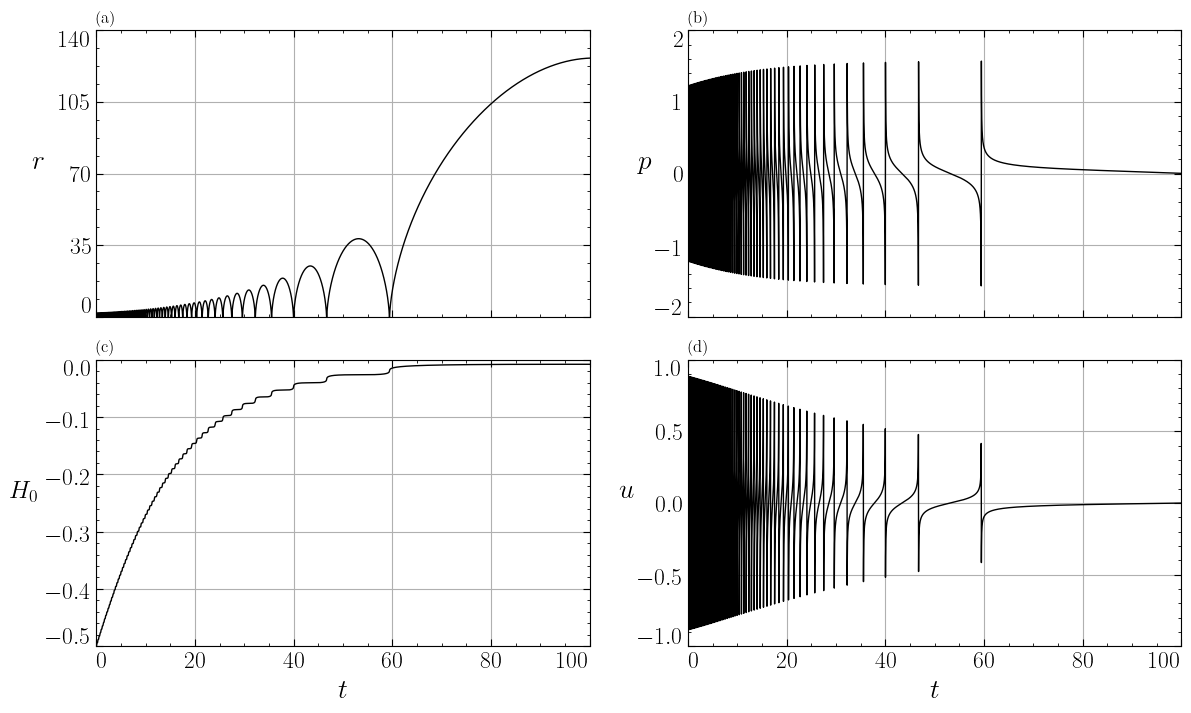

In [12]:
figCt1, axsCt1 = plt.subplots(2, 2, sharex=True)
figCt1.set_figwidth(14)
figCt1.set_figheight(8)

figCt1.subplots_adjust(wspace=0.2, hspace=0.15)

axsCt1[0, 0].set_title("(a)", loc='left', fontweight='bold')
axsCt1[0, 1].set_title("(b)", loc='left', fontweight='bold')
axsCt1[1, 0].set_title("(c)", loc='left', fontweight='bold')
axsCt1[1, 1].set_title("(d)", loc='left', fontweight='bold')

axsCt1[0, 0].set_ylabel("$r$", rotation=0, labelpad=15, size=20)
axsCt1[0, 1].set_ylabel("$p$", rotation=0, labelpad=7.5, size=20)
axsCt1[1, 0].set_ylabel("$H_0$", rotation=0, labelpad=15, size=18)
axsCt1[1, 1].set_ylabel("$u$", rotation=0, labelpad=7.5, size=20)

axsCt1[1, 0].set_xlabel("$t$", labelpad=5, size=20)
axsCt1[1, 1].set_xlabel("$t$", labelpad=5, size=20)

axsCt1[0, 0].set_xlim(0, 100)
axsCt1[0, 1].set_xlim(0, 100)
axsCt1[0, 0].set_xticks( np.arange(0, 120, 20) )
axsCt1[0, 1].set_xticks( np.arange(0, 120, 20) )

axsCt1[0, 0].tick_params(which='both', direction='in', right = True, top = True)
axsCt1[0, 0].tick_params(which='major', length=5)
axsCt1[0, 0].set_ylim(0, 140)
axsCt1[0, 0].set_yticks(np.arange(0, 175, 35))
axsCt1[0, 0].xaxis.set_minor_locator(AutoMinorLocator())
axsCt1[0, 0].yaxis.set_minor_locator(AutoMinorLocator())
axsCt1[0, 0].grid(True)

axsCt1[0, 1].tick_params(which='both', direction='in', right = True, top = True)
axsCt1[0, 1].tick_params(which='major', length=5)
axsCt1[0, 1].set_ylim(-2, 2)
axsCt1[0, 1].set_yticks(np.arange(-2, 3, 1))
axsCt1[0, 1].xaxis.set_minor_locator(AutoMinorLocator())
axsCt1[0, 1].yaxis.set_minor_locator(AutoMinorLocator())
axsCt1[0, 1].grid(True)

axsCt1[1, 0].tick_params(which='both', direction='in', right = True, top = True)
axsCt1[1, 0].tick_params(which='major', length=5)
axsCt1[1, 0].set_ylim(-0.5, 0.)
axsCt1[1, 0].set_yticks(np.arange(-0.5, 0.1, 0.1))
axsCt1[1, 0].xaxis.set_minor_locator(AutoMinorLocator())
axsCt1[1, 0].yaxis.set_minor_locator(AutoMinorLocator())
axsCt1[1, 0].grid(True)

axsCt1[1, 1].tick_params(which='both', direction='in', right = True, top = True)
axsCt1[1, 1].tick_params(which='major', length=5)
axsCt1[1, 1].set_ylim(-1, 1)
axsCt1[1, 1].set_yticks(np.arange(-1, 1.5, 0.5))
axsCt1[1, 1].xaxis.set_minor_locator(AutoMinorLocator())
axsCt1[1, 1].yaxis.set_minor_locator(AutoMinorLocator())
axsCt1[1, 1].grid(True)

axsCt1[0, 0].plot(time*aufts, rvec,      markersize=0, c="black", lw=1)
axsCt1[0, 1].plot(time*aufts, pvec,      markersize=0, c="black", lw=1)
axsCt1[1, 0].plot(time*aufts, E0vec,     markersize=0, c="black", lw=1)
axsCt1[1, 1].plot(time*aufts, uvec*auVm, markersize=0, c="black", lw=1)

for i in range(2):
    for j in range(2):
        for label in axsCt1[i, j].get_xticklabels():
            label.set_fontsize(17)
        if i != 0:
            axsCt1[i, j].get_xticklabels()[0].set_horizontalalignment("left")
            axsCt1[i, j].get_xticklabels()[-1].set_horizontalalignment("right")
        for label in axsCt1[i, j].get_yticklabels():
            label.set_fontsize(17)
        axsCt1[i, j].get_yticklabels()[0].set_verticalalignment("bottom")
        axsCt1[i, j].get_yticklabels()[-1].set_verticalalignment("top")

In [13]:
figdir = "Figures/take7/"

In [15]:
figCt1.savefig(figdir + "Figure_5" + ".pdf", bbox_inches="tight")

final time= 2067.0687287875494 50.0
t0 parameter=  928.9406867171247
number of time steps=  413414 50.00003074915781 50.0
Posição inicial= 1.797748591989436
Momento inicial= -0.33284450660350395
Campo em t=0 = 0.0007166108910134534
50.00003074915781

transfered Energy =  0.5439231720080936
Cost Functional=  0.0009111411651477033

Campo em t=t_f = -0.06201563310869314
derivada do potencial em r(tf)=  5.10389557739626e-05
Posição final= 139.974506033049
Momento final= 0.18066119665209068


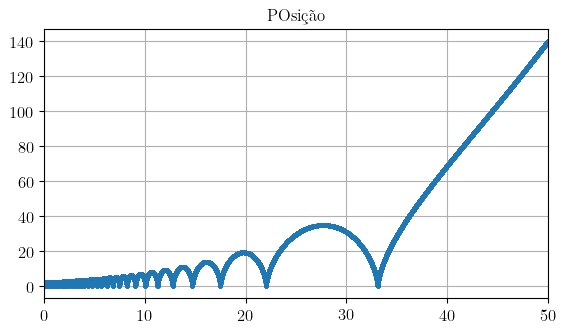

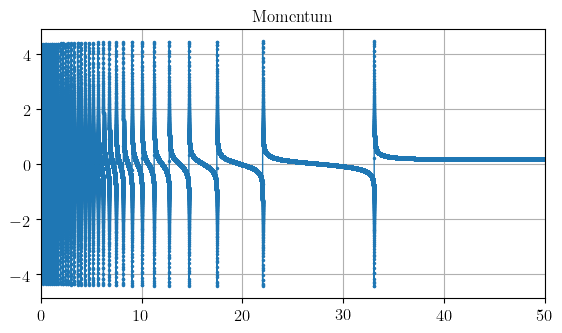

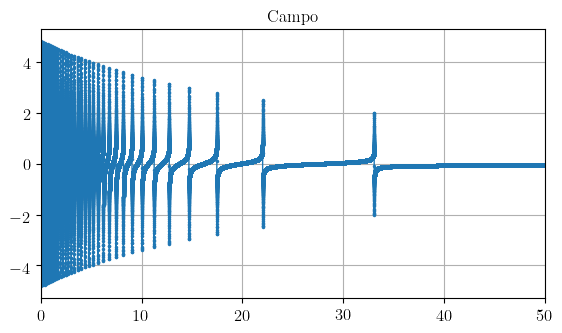

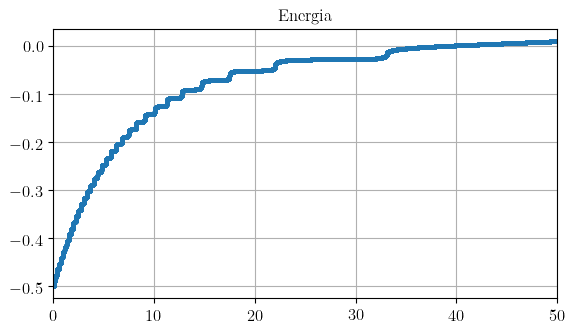

In [16]:

# -*- coding: utf-8 -*-
"""
Created on September 2024

@author: Emanuel Fernandes de Lima

Optimal solution of classical dynamics: intrinsic optimal solution

"""

import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

#parâmetros (globais) de conversão
auVm=5.14220826e2 # 1 atomic unit in 1.e9 V/m
aufts=0.02418884254 # 1 au em femtosegundos
audebye=2.541746 # 1 au in debye
aueV=27.211324570273 # 1 au in eV


# MsC softening parameter
alpha=0.1  #0.125
alphsq2=alpha*np.sqrt(2)

# Parameter for the Morse potential
q=1.
m=1.

#parameters for the calculations
t0=22.47/aufts
tf=50/aufts  #40

print("final time=",tf, tf*aufts)
print("t0 parameter= ",t0)

# Parameter for the evolution
dt=0.005
n=round(tf/dt)
time=np.zeros(n+1)

print("number of time steps= ",n,n*dt*aufts,tf*aufts)

#Position, momentum and field vectors
x=np.zeros(2)
rvec=np.zeros(n+1)
pvec=np.zeros(n+1)
uvec=np.zeros(n+1)
E0vec=np.zeros(n+1)
def V(y):
  if y>0. :
    return -1/np.sqrt(y**2+alpha**2)
  else:
    return (np.exp(-2*y/alphsq2)-2*np.exp(-y/alphsq2))/alpha

def dV(y):
  if y>0. :
    return y/(y**2+alpha**2)**(1.5)
  else:
    return (2/alpha/alphsq2)*(-np.exp(-2*y/alphsq2)+np.exp(-y/alphsq2))

def u(p,t):
  return -2*p/(q*(t+t0))

def eqdiff(t,x):
  dx=np.zeros(2)
  dx[0]=x[1]/m
  dx[1]=-dV(x[0])+2*x[1]/(t+t0)
  return dx

#Runge-Kutta
def rk4(t,x,dt):
  k1=eqdiff(t,x)
  k2=eqdiff(t+dt/2,x+dt*k1/2)
  k3=eqdiff(t+dt/2,x+dt*k2/2)
  k4=eqdiff(t+dt,x+dt*k3)
  return x+dt*(k1+2*k2+2*k3+k4)/6

# Condições iniciais
time[0]=0
Ei=-0.5# initial energy
retorn=np.sqrt(1/Ei**2-alpha**2)
x[0]=0.9*retorn
x[1]=-np.sqrt(2*(Ei-V(x[0]))) #
rvec[0]=x[0]
pvec[0]=x[1]
uvec[0]=-2*pvec[0]/q/t0
E0vec[0]=0.5*pvec[0]**2+V(rvec[0])

print("Posição inicial=",rvec[0])
print("Momento inicial=",pvec[0])
print("Campo em t=0 =",uvec[0])

#Iteração
for i in range(n):
  t=dt*i
  x=rk4(t,x,dt)
  time[i+1]=t+dt
  rvec[i+1]=x[0]
  pvec[i+1]=x[1]
  uvec[i+1]=-2*pvec[i+1]/(t+dt+t0)/q
  E0vec[i+1]=0.5*pvec[i+1]**2+V(rvec[i+1])

print(time[-1]*aufts)

print()
print("transfered Energy = ",integrate.simpson(-pvec*uvec*q, dx=dt))
print("Cost Functional= ",integrate.simpson(uvec**2, dx=dt))
print()

print("Campo em t=t_f =",uvec[-1]*auVm)
print("derivada do potencial em r(tf)= ",dV(rvec[-1]))
print("Posição final=",rvec[n])
print("Momento final=",pvec[n])

plt.plot(time*aufts,rvec)
plt.xlim(0,tf*aufts)
plt.title("POsição")
plt.grid()
plt.show()

plt.plot(time*aufts,pvec)
plt.title("Momentum")
plt.xlim(0,tf*aufts)
plt.grid()
plt.show()

plt.plot(time*aufts,uvec*auVm)#,marker='.'
plt.title("Campo")
plt.xlim(0,tf*aufts)
plt.grid()
plt.show()


plt.plot(time*aufts,E0vec)#,marker='.'
plt.title("Energia")
plt.xlim(0,tf*aufts)
plt.grid()
plt.show()








 # 428.083320148944
#Cost Functional=  6.868004185759812


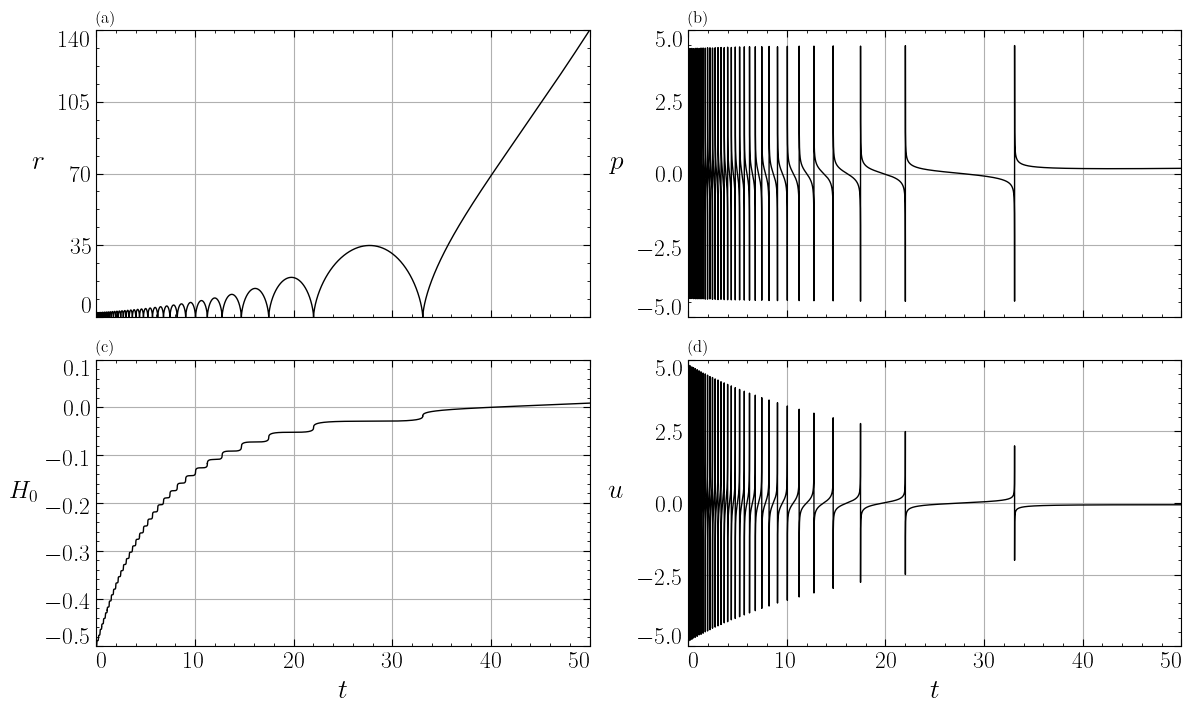

In [17]:
figCt2, axsCt2 = plt.subplots(2, 2, sharex=True)
figCt2.set_figwidth(14)
figCt2.set_figheight(8)

figCt2.subplots_adjust(wspace=0.2, hspace=0.15)

axsCt2[0, 0].set_title("(a)", loc='left', fontweight='bold')
axsCt2[0, 1].set_title("(b)", loc='left', fontweight='bold')
axsCt2[1, 0].set_title("(c)", loc='left', fontweight='bold')
axsCt2[1, 1].set_title("(d)", loc='left', fontweight='bold')

axsCt2[0, 0].set_ylabel("$r$", rotation=0, labelpad=15, size=20)
axsCt2[0, 1].set_ylabel("$p$", rotation=0, labelpad=15, size=20)
axsCt2[1, 0].set_ylabel("$H_0$", rotation=0, labelpad=15, size=18)
axsCt2[1, 1].set_ylabel("$u$", rotation=0, labelpad=15, size=20)

axsCt2[1, 0].set_xlabel("$t$", labelpad=5, size=20)
axsCt2[1, 1].set_xlabel("$t$", labelpad=5, size=20)

axsCt2[0, 0].set_xlim(0, 50)
axsCt2[0, 1].set_xlim(0, 50)
axsCt2[0, 0].set_xticks( np.arange(0, 60, 10) )
axsCt2[0, 1].set_xticks( np.arange(0, 60, 10) )

axsCt2[0, 0].tick_params(which='both', direction='in', right = True, top = True)
axsCt2[0, 0].tick_params(which='major', length=5)
axsCt2[0, 0].set_ylim(0, 140)
axsCt2[0, 0].set_yticks(np.arange(0, 175, 35))
axsCt2[0, 0].xaxis.set_minor_locator(AutoMinorLocator())
axsCt2[0, 0].yaxis.set_minor_locator(AutoMinorLocator())
axsCt2[0, 0].grid(True)

axsCt2[0, 1].tick_params(which='both', direction='in', right = True, top = True)
axsCt2[0, 1].tick_params(which='major', length=5)
axsCt2[0, 1].set_ylim(-5, 5)
axsCt2[0, 1].set_yticks(np.arange(-5, 7.5, 2.5))
axsCt2[0, 1].xaxis.set_minor_locator(AutoMinorLocator())
axsCt2[0, 1].yaxis.set_minor_locator(AutoMinorLocator())
axsCt2[0, 1].grid(True)

axsCt2[1, 0].tick_params(which='both', direction='in', right = True, top = True)
axsCt2[1, 0].tick_params(which='major', length=5)
axsCt2[1, 0].set_ylim(-0.5, 0.1)
axsCt2[1, 0].set_yticks(np.arange(-0.5, 0.2, 0.1))
axsCt2[1, 0].xaxis.set_minor_locator(AutoMinorLocator())
axsCt2[1, 0].yaxis.set_minor_locator(AutoMinorLocator())
axsCt2[1, 0].grid(True)

axsCt2[1, 1].tick_params(which='both', direction='in', right = True, top = True)
axsCt2[1, 1].tick_params(which='major', length=5)
axsCt2[1, 1].set_ylim(-5, 5)
axsCt2[1, 1].set_yticks(np.arange(-5, 7.5, 2.5))
axsCt2[1, 1].xaxis.set_minor_locator(AutoMinorLocator())
axsCt2[1, 1].yaxis.set_minor_locator(AutoMinorLocator())
axsCt2[1, 1].grid(True)

axsCt2[0, 0].plot(time*aufts, rvec,      markersize=0, c="black", lw=1)
axsCt2[0, 1].plot(time*aufts, pvec,      markersize=0, c="black", lw=1)
axsCt2[1, 0].plot(time*aufts, E0vec,     markersize=0, c="black", lw=1)
axsCt2[1, 1].plot(time*aufts, uvec*auVm, markersize=0, c="black", lw=1)

for i in range(2):
    for j in range(2):
        for label in axsCt2[i, j].get_xticklabels():
            label.set_fontsize(17)
        if i != 0:
            axsCt2[i, j].get_xticklabels()[0].set_horizontalalignment("left")
            axsCt2[i, j].get_xticklabels()[-1].set_horizontalalignment("right")
        for label in axsCt2[i, j].get_yticklabels():
            label.set_fontsize(17)
        axsCt2[i, j].get_yticklabels()[0].set_verticalalignment("bottom")
        axsCt2[i, j].get_yticklabels()[-1].set_verticalalignment("top")

In [18]:
figCt2.savefig(figdir + "Figure_6" + ".pdf", bbox_inches="tight")